# OBIETTIVO: Reynolds number comparison analysis

This notebook compares HOSVD core tensors across different Reynolds numbers: Re = [7000, 8000, 9000, 10000]

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
import kagglehub
import global_variables

## Data Loading
Load data for all Reynolds numbers: 7000, 8000, 9000, 10000

In [2]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10

# Reynolds numbers to compare
reynolds_numbers = [7000, 8000, 9000, 10000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]

data_paths = [kagglehub.dataset_download(name) for name in paths]

# Get metadata from first dataset (assuming same grid for all Re)
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
    
Nx, Ny = metadata['global']['Nxyz']
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map
Lx, Ly = global_variables.Lx, global_variables.Ly

print(f"Grid dimensions: Nx={Nx}, Ny={Ny}")
print(f"Subsampled grid: Nx_sub={Nx_sub}, Ny_sub={Ny_sub}")
print(f"Reynolds numbers: {reynolds_numbers}")

Grid dimensions: Nx=1600, Ny=2000
Subsampled grid: Nx_sub=160, Ny_sub=200
Reynolds numbers: [7000, 8000, 9000, 10000]


In [3]:
tensors = {}
for data_path, re_num in zip(data_paths, reynolds_numbers):
    key = f"Re{re_num}"
    print(f"\nLoading data for {key}...")
    
    # Load metadata for this dataset
    with open(data_path + '/info.json') as f:
        metadata_re = json.load(f)
    
    tensor = np.zeros((Ny//subsample_y, Nx//subsample_x, n_species, n_snapshots))
    
    for t_idx in tqdm(range(n_snapshots), desc=f"Loading {key} snapshots"):
        for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
            filename_key = file_key_map[comp_name]
            filename = metadata_re['local'][t_idx][filename_key]
            data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
            molar_data = data / molar_masses[comp_name]
            tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    
    tensors[key] = tensor
    print(f"{key} tensor shape: {tensor.shape}")


Loading data for Re7000...


Loading Re7000 snapshots: 100%|██████████| 200/200 [00:21<00:00,  9.38it/s]


Re7000 tensor shape: (200, 160, 8, 200)

Loading data for Re8000...


Loading Re8000 snapshots: 100%|██████████| 200/200 [00:22<00:00,  9.06it/s]


Re8000 tensor shape: (200, 160, 8, 200)

Loading data for Re9000...


Loading Re9000 snapshots: 100%|██████████| 200/200 [00:24<00:00,  8.27it/s]


Re9000 tensor shape: (200, 160, 8, 200)

Loading data for Re10000...


Loading Re10000 snapshots: 100%|██████████| 200/200 [00:23<00:00,  8.57it/s]

Re10000 tensor shape: (200, 160, 8, 200)


## Tensor Scaling and Centering
Apply log-scaling and standardization to all datasets

In [4]:
def scale_and_center_tensors(tensors, component_names, log_scale=True, 
                             temporal_m=False, std_scale=True, epsilon=1e-12):
    tensors_scaled = {}
    
    for dataset_path, tensor in tensors.items():
        tensor_scaled = tensor.copy()  # Shape: (x, y, species, t)        
        for c_idx, comp_name in enumerate(component_names):
            component_data = tensor_scaled[:, :, c_idx, :].copy()            
            if log_scale:
                component_data = np.log10(np.maximum(component_data, epsilon))
            if temporal_m:
                temporal_mean = component_data.mean(axis=-1, keepdims=True)  # Mean over time
                component_data = component_data - temporal_mean
            if std_scale:
                mean_val = component_data.mean()  # Should be ~0 if temporal_m=True
                print(f"Component: {comp_name}, Mean before scaling: {mean_val}")
                std_val = component_data.std()                
                if std_val < epsilon:
                    std_val = epsilon  # Prevent divide-by-zero
                
                component_data = (component_data - mean_val) / std_val
            
            # Store processed component
            tensor_scaled[:, :, c_idx, :] = component_data
        
        tensors_scaled[dataset_path] = tensor_scaled
    
    return tensors_scaled

In [5]:
# Apply standard scaling with log-transform
tensors_scaled = scale_and_center_tensors(tensors, component_names, log_scale=True, temporal_m=False, std_scale=True)

print("Scaled tensors:")
for key in tensors_scaled.keys():
    print(f"  {key}: {tensors_scaled[key].shape}")
    

Component: YH, Mean before scaling: -9.139946406298609
Component: YH2, Mean before scaling: -7.7747852903736385
Component: YO, Mean before scaling: -9.234814255583336
Component: YO2, Mean before scaling: -2.31353002855837
Component: YOH, Mean before scaling: -9.069075874570347
Component: YH2O, Mean before scaling: -8.49186933635022
Component: YHO2, Mean before scaling: -9.9137912767251
Component: YH2O2, Mean before scaling: -10.551209553985153
Component: YH, Mean before scaling: -9.2129317645393
Component: YH2, Mean before scaling: -7.728262101421571
Component: YO, Mean before scaling: -9.351383053924385
Component: YO2, Mean before scaling: -2.3096448452928096
Component: YOH, Mean before scaling: -9.191933502835676
Component: YH2O, Mean before scaling: -8.616590303459619
Component: YHO2, Mean before scaling: -9.961307326507173
Component: YH2O2, Mean before scaling: -10.609574866602188
Component: YH, Mean before scaling: -9.336732469406043
Component: YH2, Mean before scaling: -7.8161972

## HOSVD Decomposition
Perform Higher-Order Singular Value Decomposition for all Reynolds numbers

In [6]:
decomposition_results = {}  # store factors and cores per dataset

for dataset_key, tensor in tensors_scaled.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for: {dataset_key}")
    print("=" * 100)
    print(f"Tensor shape: (Ny={tensor.shape[0]}, Nx={tensor.shape[1]}, n_chem={tensor.shape[2]}, n_time={tensor.shape[3]})")
    
    # Compute factor matrices for each mode
    print("Computing U_y (mode 0: spatial Y)...")
    U_y, _, _ = np.linalg.svd(tl.unfold(tensor, mode=0), full_matrices=False)
    
    print("Computing U_x (mode 1: spatial X)...")
    U_x, _, _ = np.linalg.svd(tl.unfold(tensor, mode=1), full_matrices=False)
    
    print("Computing U_chem (mode 2: chemical)...")
    U_chem, _, _ = np.linalg.svd(tl.unfold(tensor, mode=2), full_matrices=False)
    
    print("Computing U_time (mode 3: time)...")
    U_time, _, _ = np.linalg.svd(tl.unfold(tensor, mode=3), full_matrices=False)
    
    # Compute core tensor
    print("Computing core tensor...")
    core = multi_mode_dot(tensor, [U_y.T, U_x.T, U_chem.T, U_time.T], modes=[0, 1, 2, 3])
    
    decomposition_results[dataset_key] = {
        "core": core,
        "U_y": U_y,
        "U_x": U_x,
        "U_chem": U_chem,
        "U_time": U_time,
        "factors": [U_y, U_x, U_chem, U_time],
    }
    
    print(f"Core tensor shape: {core.shape}")
    print(f"Core tensor norm: {np.linalg.norm(core):.4f}")

print("\n" + "=" * 100)
print("HOSVD decomposition completed for all Reynolds numbers")
print("=" * 100)


Performing HOSVD for: Re7000
Tensor shape: (Ny=200, Nx=160, n_chem=8, n_time=200)
Computing U_y (mode 0: spatial Y)...


Computing U_x (mode 1: spatial X)...
Computing U_chem (mode 2: chemical)...
Computing U_time (mode 3: time)...
Computing core tensor...
Core tensor shape: (200, 160, 8, 200)
Core tensor norm: 7155.4175

Performing HOSVD for: Re8000
Tensor shape: (Ny=200, Nx=160, n_chem=8, n_time=200)
Computing U_y (mode 0: spatial Y)...
Computing U_x (mode 1: spatial X)...
Computing U_chem (mode 2: chemical)...
Computing U_time (mode 3: time)...
Computing core tensor...
Core tensor shape: (200, 160, 8, 200)
Core tensor norm: 7155.4175

Performing HOSVD for: Re9000
Tensor shape: (Ny=200, Nx=160, n_chem=8, n_time=200)
Computing U_y (mode 0: spatial Y)...
Computing U_x (mode 1: spatial X)...
Computing U_chem (mode 2: chemical)...
Computing U_time (mode 3: time)...
Computing core tensor...
Core tensor shape: (200, 160, 8, 200)
Core tensor norm: 7155.4175

Performing HOSVD for: Re10000
Tensor shape: (Ny=200, Nx=160, n_chem=8, n_time=200)
Computing U_y (mode 0: spatial Y)...
Computing U_x (mode 1: spatial X)

## Core Tensor Singular Values Comparison
Compare core tensor structure across different Reynolds numbers

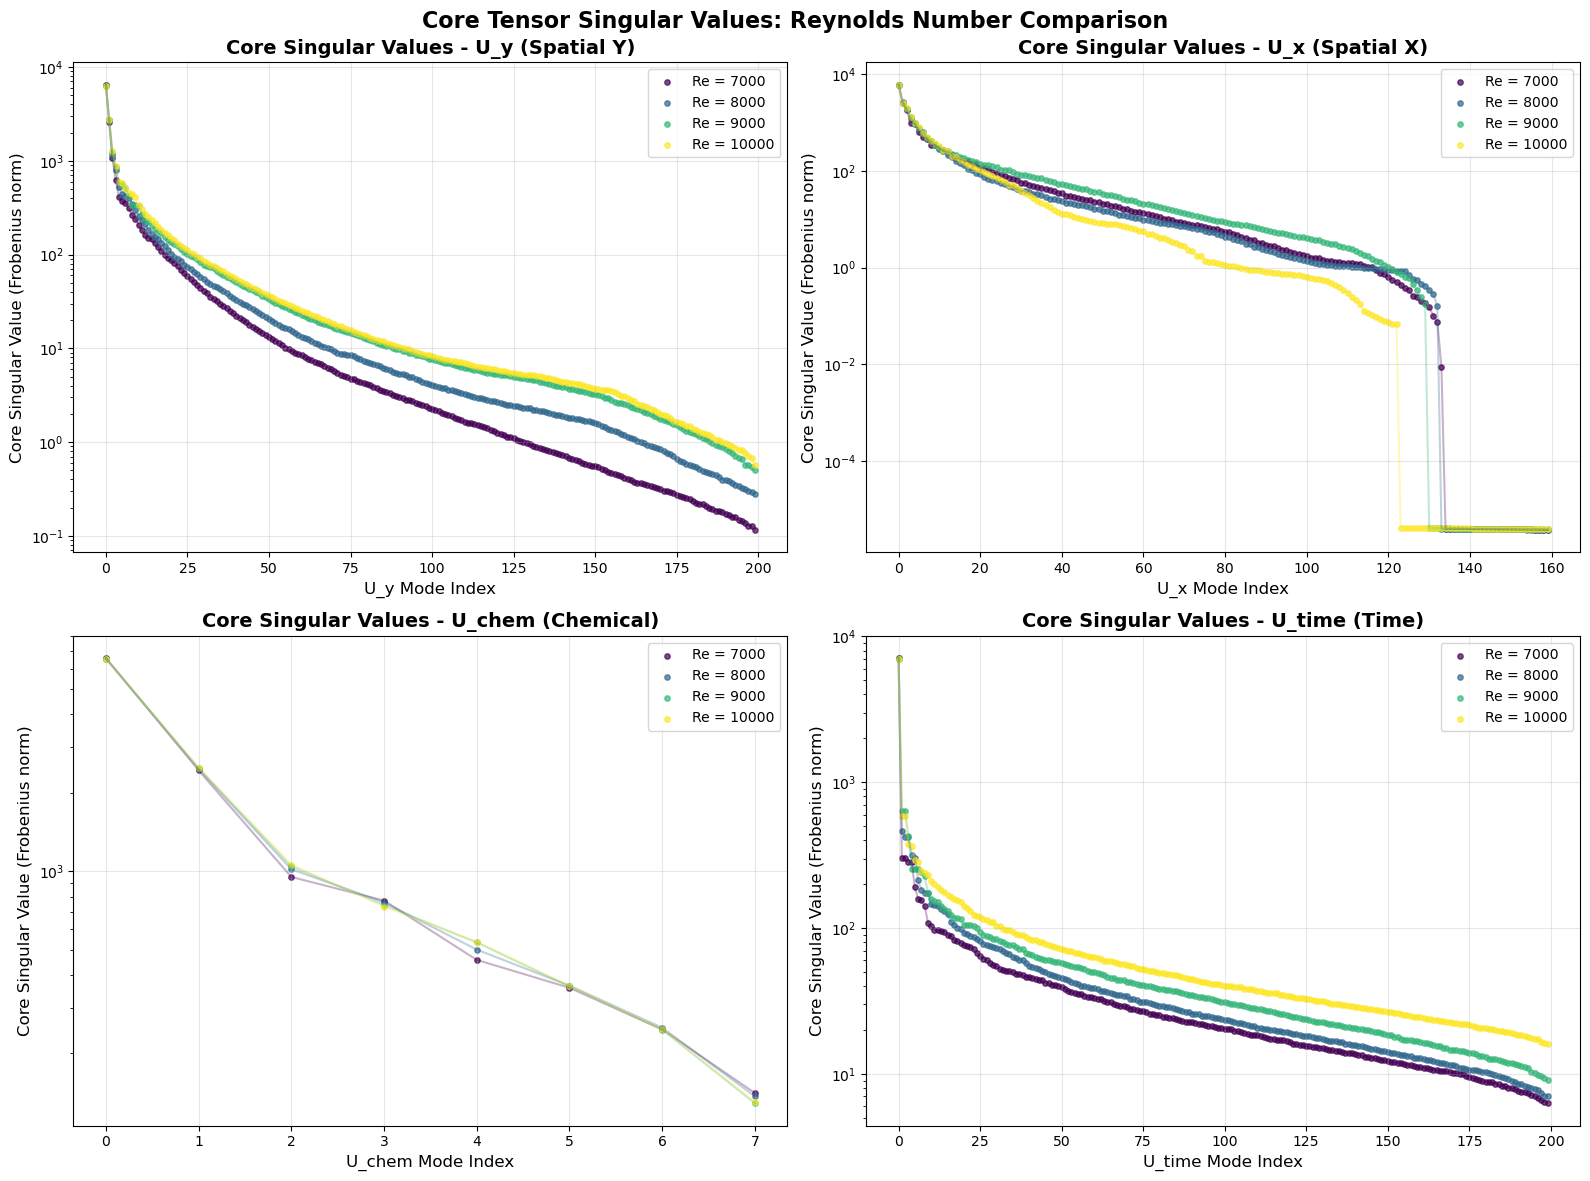

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = plt.cm.viridis(np.linspace(0, 1, len(reynolds_numbers)))

for idx, (re_num, color) in enumerate(zip(reynolds_numbers, colors)):
    key = f"Re{re_num}"
    core = decomposition_results[key]['core']
    label = f"Re = {re_num}"
    
    # Spatial Y dimension (U_y)
    sv_y = [np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])]
    ax = axes[0, 0]
    ax.scatter(range(len(sv_y)), sv_y, color=color, s=15, alpha=0.7, label=label)
    ax.plot(range(len(sv_y)), sv_y, color=color, alpha=0.3, linewidth=1.5)
    
    # Spatial X dimension (U_x)
    sv_x = [np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])]
    ax = axes[0, 1]
    ax.scatter(range(len(sv_x)), sv_x, color=color, s=15, alpha=0.7, label=label)
    ax.plot(range(len(sv_x)), sv_x, color=color, alpha=0.3, linewidth=1.5)
    
    # Chemical dimension (U_chem)
    sv_chem = [np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]
    ax = axes[1, 0]
    ax.scatter(range(len(sv_chem)), sv_chem, color=color, s=15, alpha=0.7, label=label)
    ax.plot(range(len(sv_chem)), sv_chem, color=color, alpha=0.3, linewidth=1.5)
    
    # Time dimension (U_time)
    sv_time = [np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])]
    ax = axes[1, 1]
    ax.scatter(range(len(sv_time)), sv_time, color=color, s=15, alpha=0.7, label=label)
    ax.plot(range(len(sv_time)), sv_time, color=color, alpha=0.3, linewidth=1.5)

# Spatial Y
ax = axes[0, 0]
ax.set_xlabel('U_y Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_y (Spatial Y)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

# Spatial X
ax = axes[0, 1]
ax.set_xlabel('U_x Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_x (Spatial X)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

# Chemical
ax = axes[1, 0]
ax.set_xlabel('U_chem Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_chem (Chemical)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

# Time
ax = axes[1, 1]
ax.set_xlabel('U_time Mode Index', fontsize=12)
ax.set_ylabel('Core Singular Value (Frobenius norm)', fontsize=12)
ax.set_title('Core Singular Values - U_time (Time)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.legend(fontsize=10, loc='best')

fig.suptitle('Core Tensor Singular Values: Reynolds Number Comparison', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Chemical Factor Loadings (U_chem)
Visualize how chemical species contribute to each mode for different Re

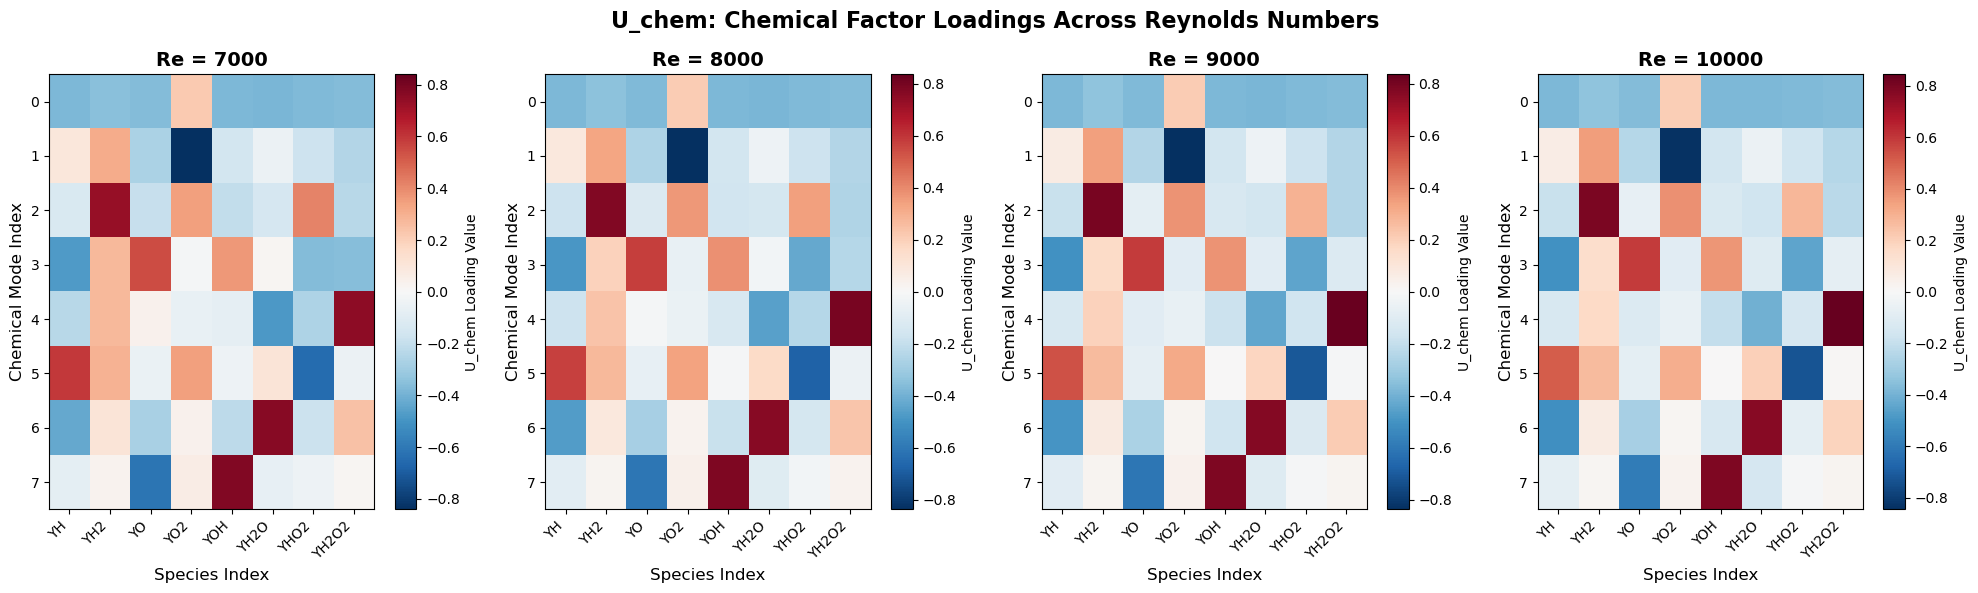

In [8]:
# Visualize Chemical Loadings with Signs for all Reynolds numbers
n_re = len(reynolds_numbers)
fig, axes = plt.subplots(1, n_re, figsize=(5*n_re, 6))

if n_re == 1:
    axes = [axes]

for idx, re_num in enumerate(reynolds_numbers):
    key = f"Re{re_num}"
    U_chem = decomposition_results[key]['U_chem']  # shape: (n_species, n_species)
    
    ax = axes[idx]
    im = ax.imshow(U_chem.T, cmap='RdBu_r', aspect='auto', 
                    vmin=-np.abs(U_chem).max(), 
                    vmax=np.abs(U_chem).max())
    ax.set_xlabel('Species Index', fontsize=12)
    ax.set_ylabel('Chemical Mode Index', fontsize=12)
    ax.set_title(f'Re = {re_num}', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(component_names)))
    ax.set_xticklabels(component_names, rotation=45, ha='right')
    plt.colorbar(im, ax=ax, label='U_chem Loading Value')

fig.suptitle('U_chem: Chemical Factor Loadings Across Reynolds Numbers', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Detailed Chemical Mode Comparison
Bar plots showing first few chemical modes for each Reynolds number

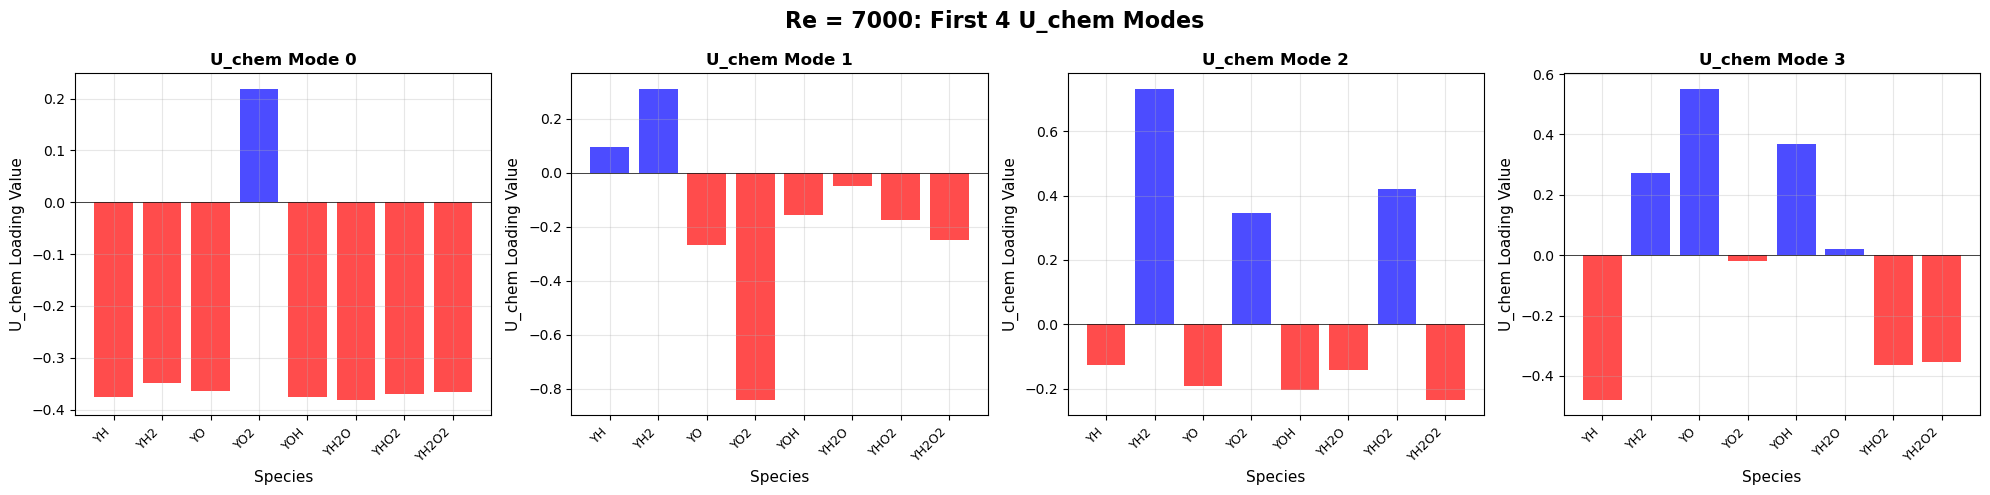

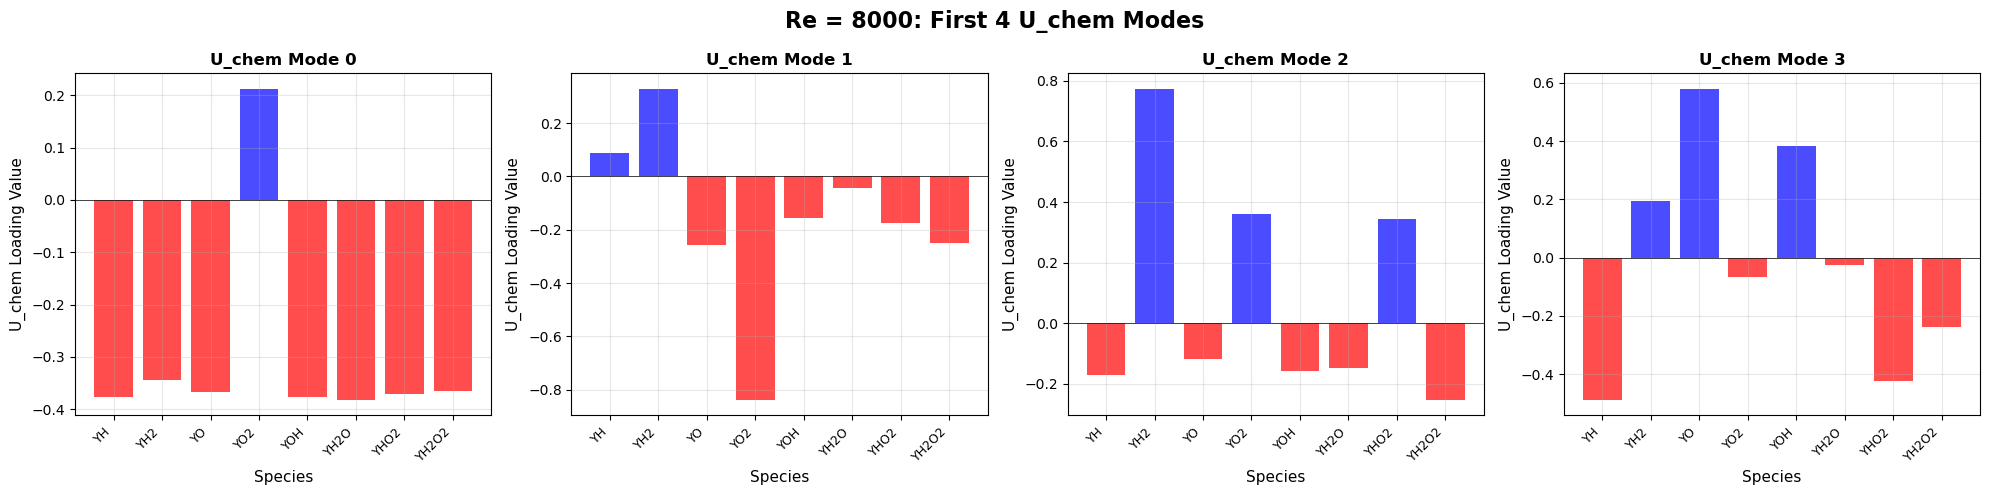

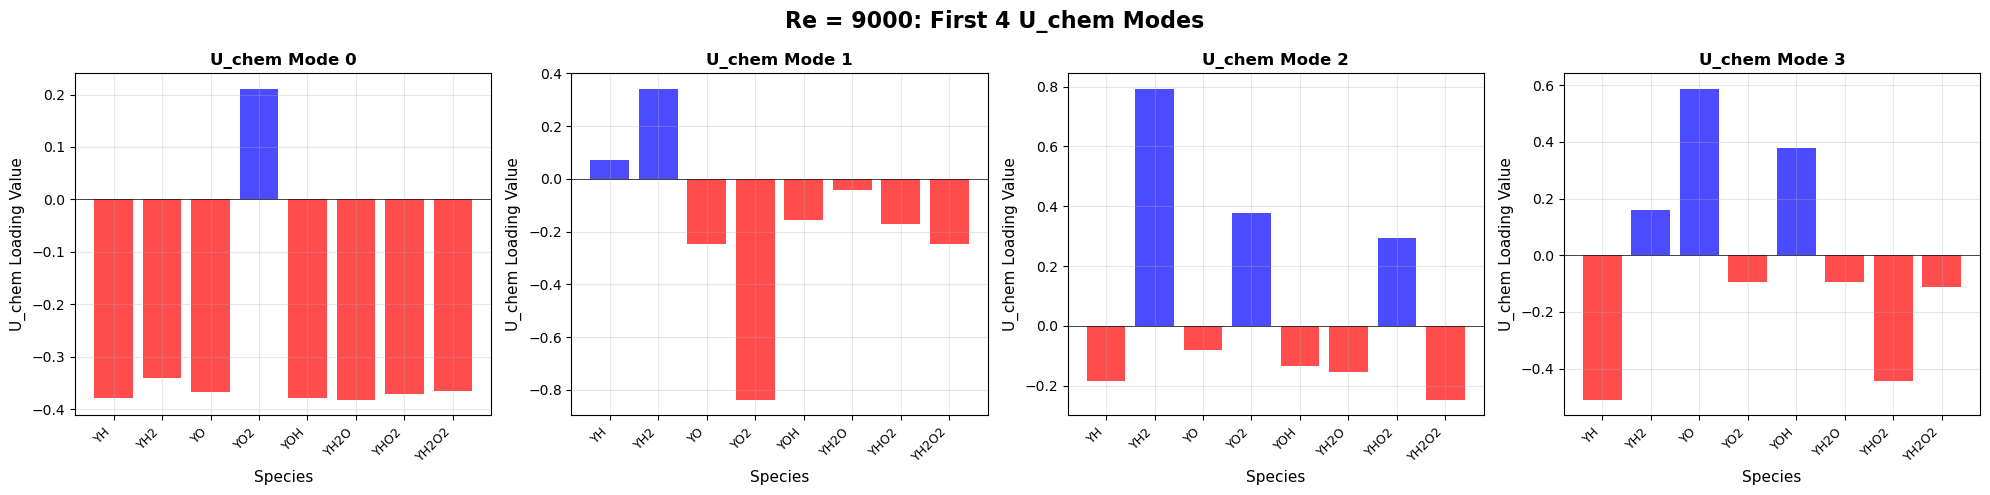

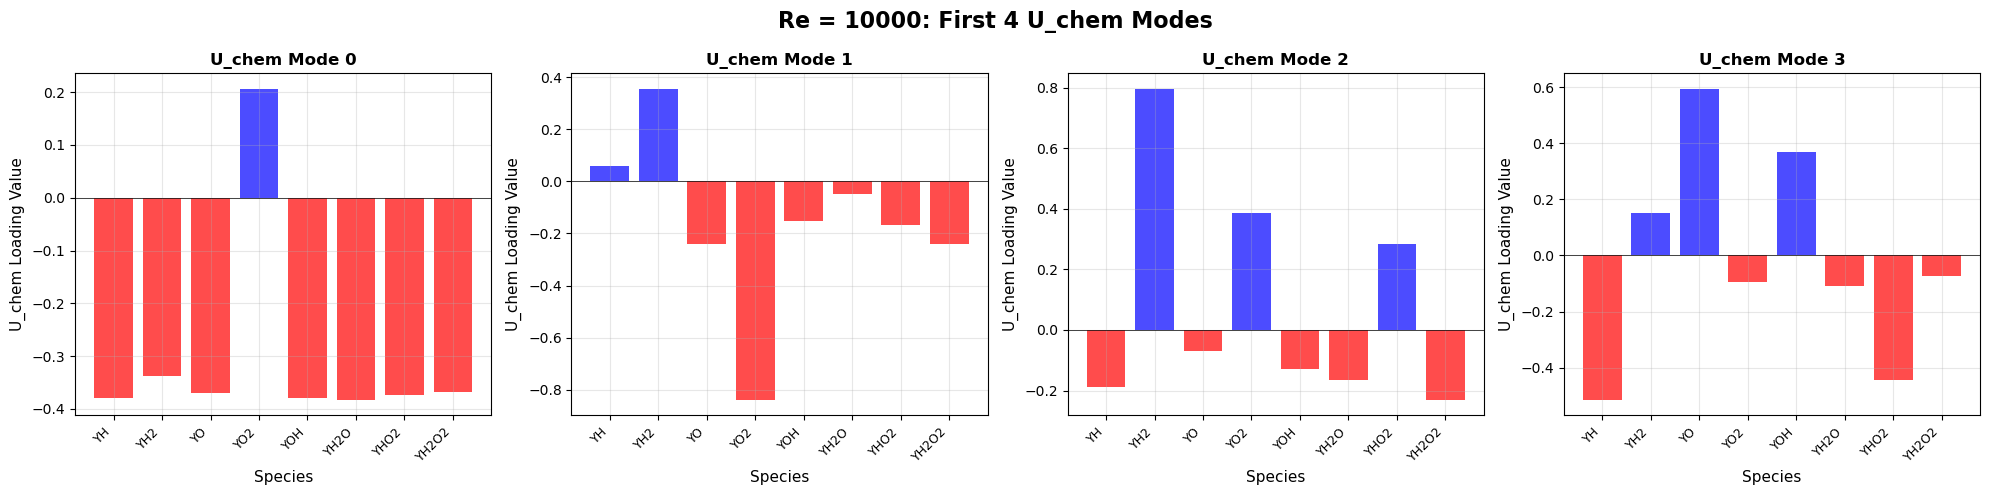

In [9]:
# Visualize first few chemical modes as bar plots
n_modes_to_show = min(4, len(component_names))

for re_num in reynolds_numbers:
    key = f"Re{re_num}"
    U_chem = decomposition_results[key]['U_chem']
    
    fig, axes = plt.subplots(1, n_modes_to_show, figsize=(20, 5))
    
    x = np.arange(len(component_names))
    
    for mode_idx in range(n_modes_to_show):
        ax = axes[mode_idx] if n_modes_to_show > 1 else axes
        values = U_chem[:, mode_idx]
        colors = ['red' if v < 0 else 'blue' for v in values]
        ax.bar(x, values, color=colors, alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.set_xlabel('Species', fontsize=11)
        ax.set_ylabel('U_chem Loading Value', fontsize=11)
        ax.set_title(f'U_chem Mode {mode_idx}', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(component_names, rotation=45, ha='right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'Re = {re_num}: First {n_modes_to_show} U_chem Modes', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Spatial Mode Coupling Analysis
Examine how spatial modes (U_y and U_x) couple through the core tensor

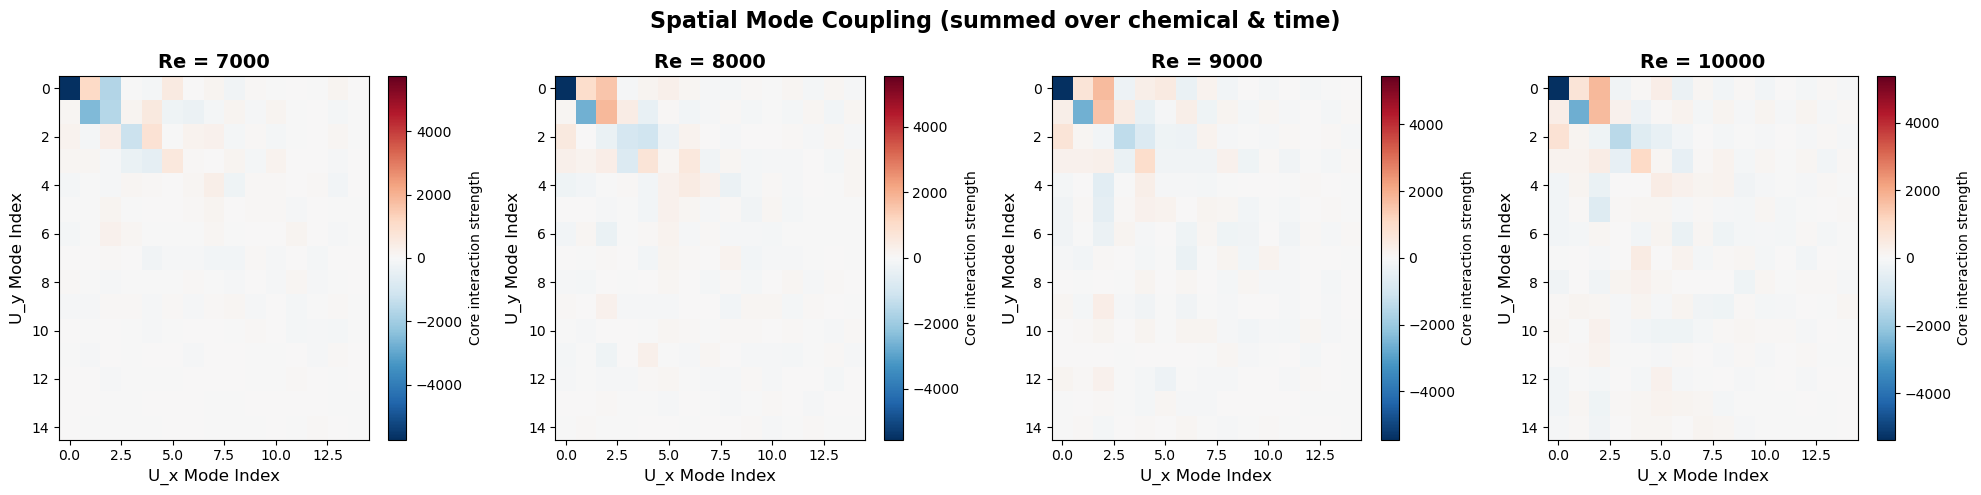

In [10]:
# Spatial coupling: sum over chemical and time dimensions
sum_axes = (2, 3)  # Chemical and time dimensions
n_y_modes = 15
n_x_modes = 15

fig, axes = plt.subplots(1, len(reynolds_numbers), figsize=(5*len(reynolds_numbers), 5))

if len(reynolds_numbers) == 1:
    axes = [axes]

for idx, re_num in enumerate(reynolds_numbers):
    key = f"Re{re_num}"
    core = decomposition_results[key]['core']
    
    # Sum over chemical and time dimensions
    spatial_coupling = np.sum(core, axis=sum_axes)[:n_y_modes, :n_x_modes]
    
    ax = axes[idx]
    im = ax.imshow(
        spatial_coupling,
        cmap='RdBu_r',
        aspect='auto',
        vmin=-np.abs(spatial_coupling).max(),
        vmax=np.abs(spatial_coupling).max()
    )
    
    ax.set_xlabel('U_x Mode Index', fontsize=12)
    ax.set_ylabel('U_y Mode Index', fontsize=12)
    ax.set_title(f"Re = {re_num}", fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax, label='Core interaction strength')

fig.suptitle(f"Spatial Mode Coupling (summed over chemical & time)", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Pairwise Reynolds Number Comparison
Compare spatial coupling between consecutive Reynolds numbers

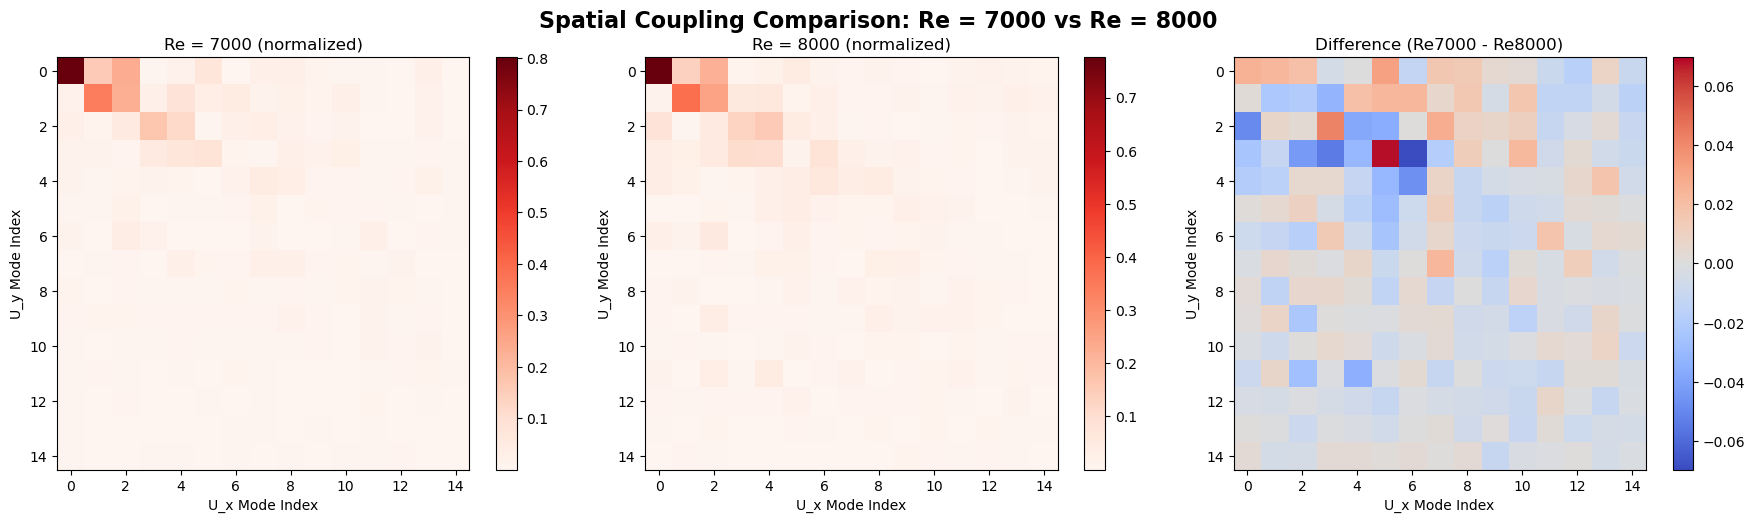

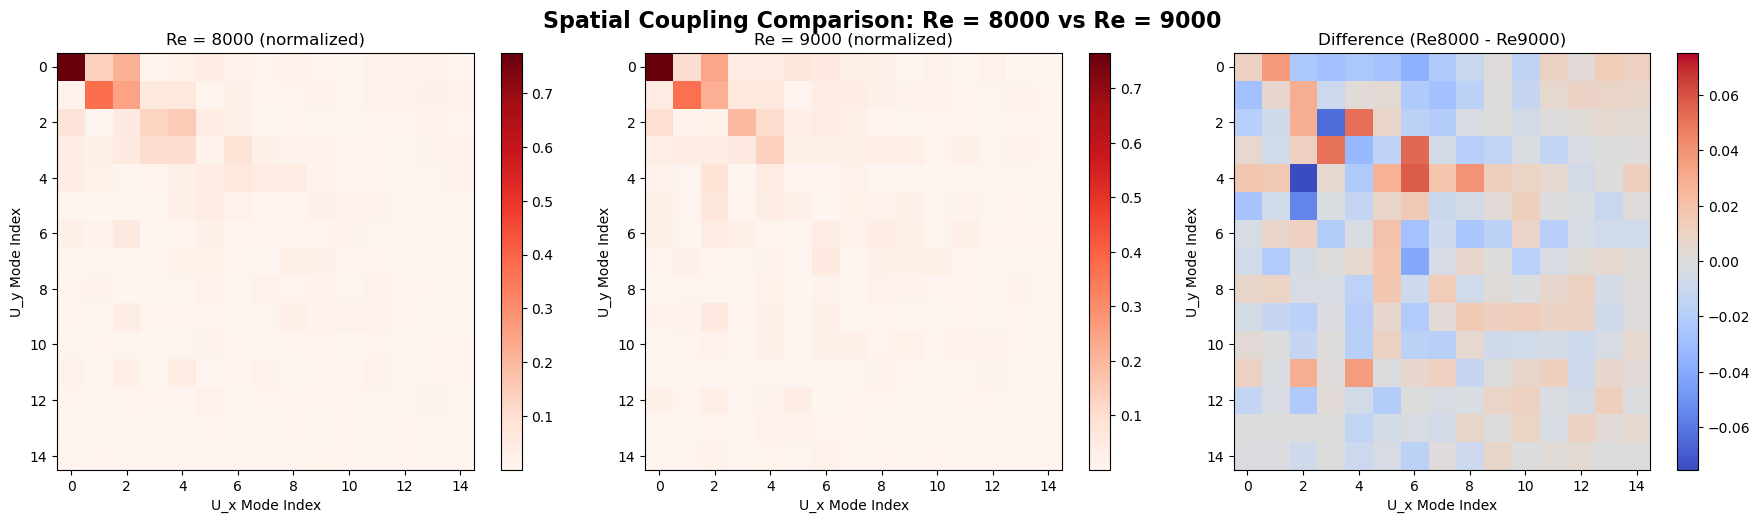

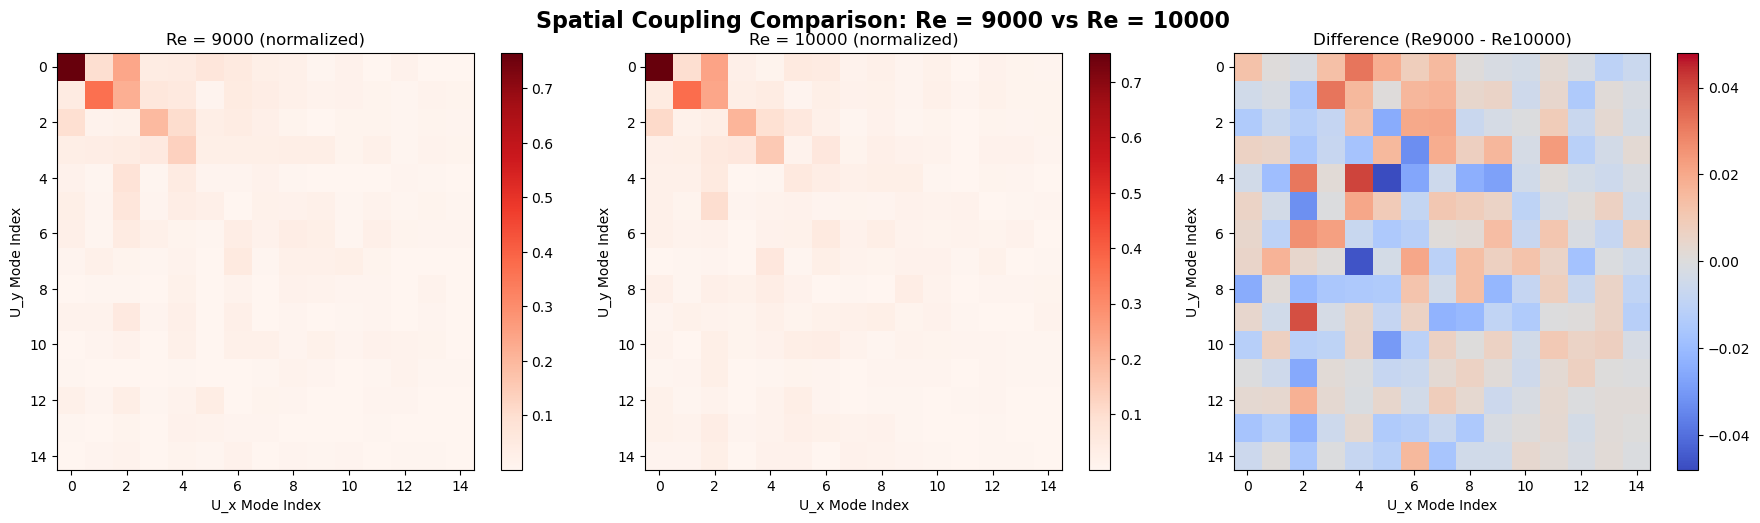

In [11]:
# Pairwise comparison between consecutive Reynolds numbers
for i in range(len(reynolds_numbers) - 1):
    re1 = reynolds_numbers[i]
    re2 = reynolds_numbers[i + 1]
    
    key1 = f"Re{re1}"
    key2 = f"Re{re2}"
    
    core1 = decomposition_results[key1]['core']
    core2 = decomposition_results[key2]['core']
    
    # Compute spatial coupling
    coupling1 = np.sum(core1, axis=(2, 3))[:n_y_modes, :n_x_modes]
    coupling2 = np.sum(core2, axis=(2, 3))[:n_y_modes, :n_x_modes]
    
    # Normalize for comparison
    coupling1_abs = np.abs(coupling1)
    coupling2_abs = np.abs(coupling2)
    
    norm1 = np.linalg.norm(coupling1_abs, 'fro')
    norm2 = np.linalg.norm(coupling2_abs, 'fro')
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # First Re
    im0 = axes[0].imshow(coupling1_abs / norm1, cmap='Reds')
    axes[0].set_xlabel('U_x Mode Index')
    axes[0].set_ylabel('U_y Mode Index')
    axes[0].set_title(f"Re = {re1} (normalized)")
    plt.colorbar(im0, ax=axes[0])
    
    # Second Re
    im1 = axes[1].imshow(coupling2_abs / norm2, cmap='Reds')
    axes[1].set_xlabel('U_x Mode Index')
    axes[1].set_ylabel('U_y Mode Index')
    axes[1].set_title(f"Re = {re2} (normalized)")
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = (coupling1_abs / norm1) - (coupling2_abs / norm2)
    im2 = axes[2].imshow(diff, cmap='coolwarm', 
                         vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
    axes[2].set_xlabel('U_x Mode Index')
    axes[2].set_ylabel('U_y Mode Index')
    axes[2].set_title(f"Difference (Re{re1} - Re{re2})")
    plt.colorbar(im2, ax=axes[2])
    
    fig.suptitle(f"Spatial Coupling Comparison: Re = {re1} vs Re = {re2}", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Energy Distribution Analysis
Analyze how energy is distributed across modes for different Reynolds numbers

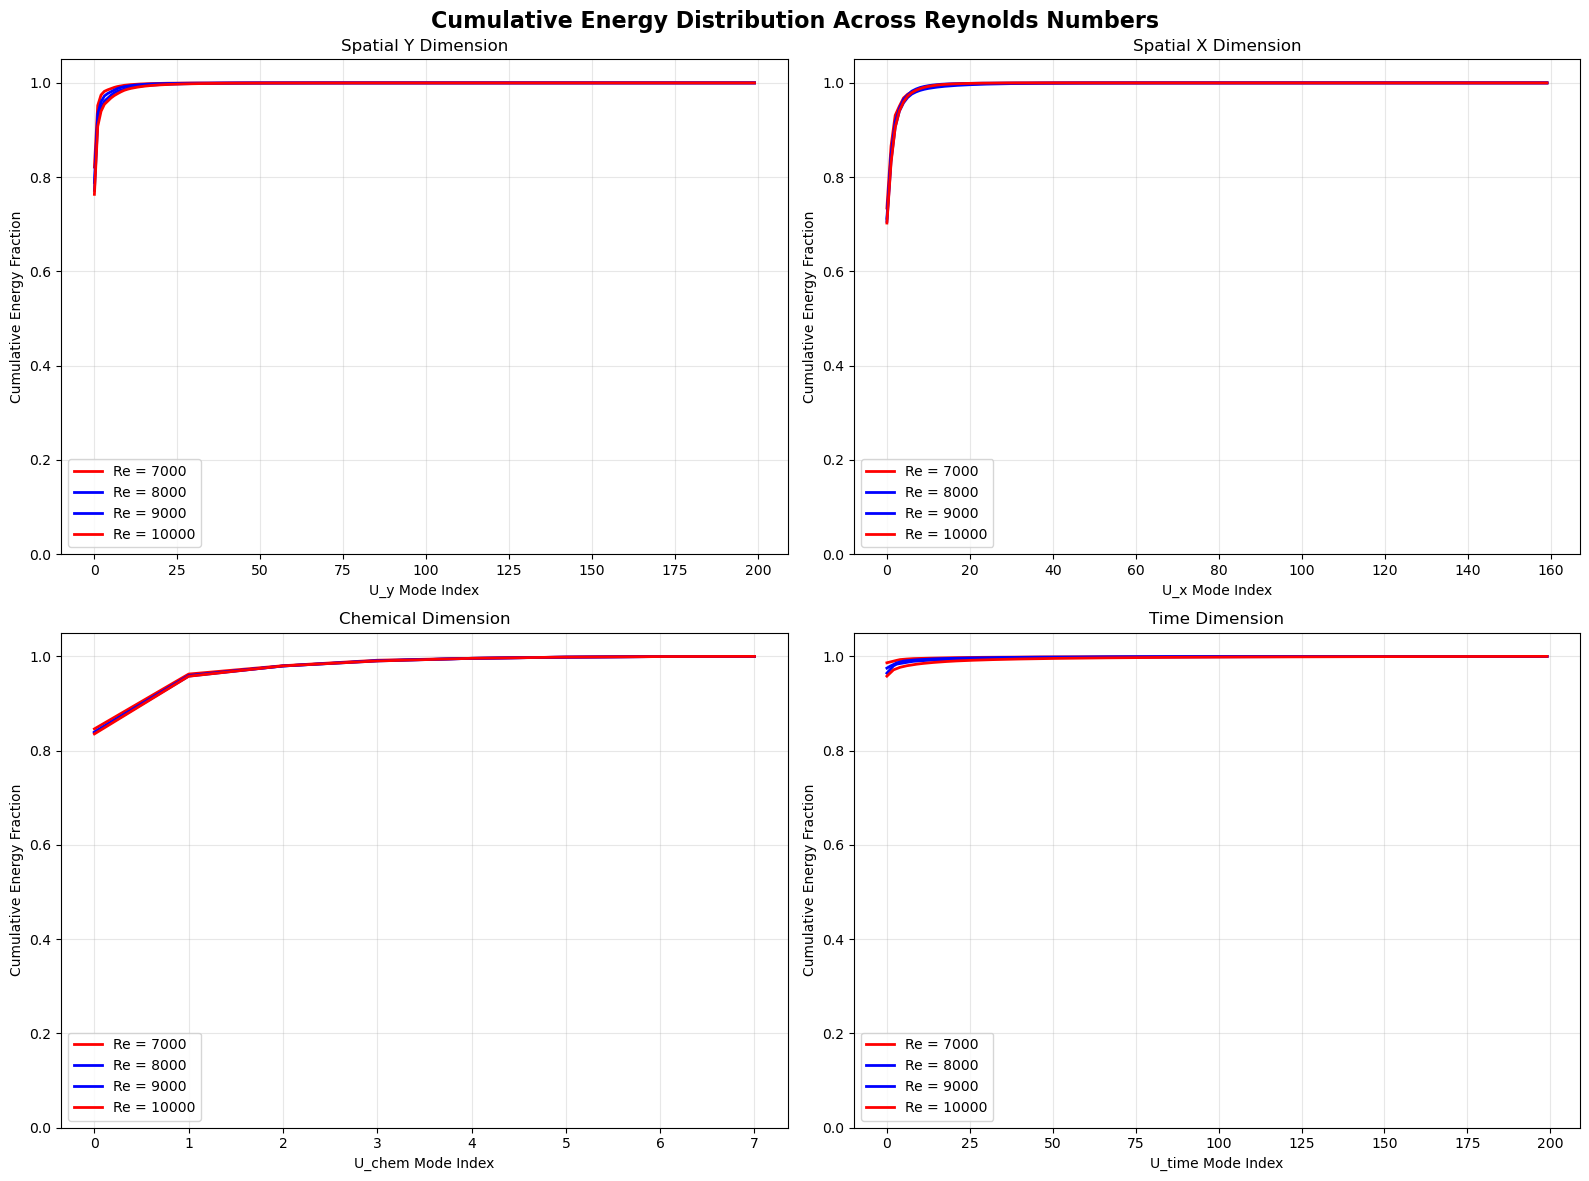

In [12]:
# Energy distribution across modes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, re_num in enumerate(reynolds_numbers):
    key = f"Re{re_num}"
    core = decomposition_results[key]['core']
    
    # Compute cumulative energy for each mode
    sv_y = np.array([np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])])
    sv_x = np.array([np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])])
    sv_chem = np.array([np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])])
    sv_time = np.array([np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])])
    
    # Normalize to get energy fractions
    energy_y = (sv_y**2) / (sv_y**2).sum()
    energy_x = (sv_x**2) / (sv_x**2).sum()
    energy_chem = (sv_chem**2) / (sv_chem**2).sum()
    energy_time = (sv_time**2) / (sv_time**2).sum()
    
    # Cumulative energy
    cum_energy_y = np.cumsum(energy_y)
    cum_energy_x = np.cumsum(energy_x)
    cum_energy_chem = np.cumsum(energy_chem)
    cum_energy_time = np.cumsum(energy_time)
    
    color = colors[idx]
    label = f"Re = {re_num}"
    
    axes[0, 0].plot(cum_energy_y, color=color, label=label, linewidth=2)
    axes[0, 1].plot(cum_energy_x, color=color, label=label, linewidth=2)
    axes[1, 0].plot(cum_energy_chem, color=color, label=label, linewidth=2)
    axes[1, 1].plot(cum_energy_time, color=color, label=label, linewidth=2)

# Format plots
axes[0, 0].set_xlabel('U_y Mode Index')
axes[0, 0].set_ylabel('Cumulative Energy Fraction')
axes[0, 0].set_title('Spatial Y Dimension')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1.05])

axes[0, 1].set_xlabel('U_x Mode Index')
axes[0, 1].set_ylabel('Cumulative Energy Fraction')
axes[0, 1].set_title('Spatial X Dimension')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1.05])

axes[1, 0].set_xlabel('U_chem Mode Index')
axes[1, 0].set_ylabel('Cumulative Energy Fraction')
axes[1, 0].set_title('Chemical Dimension')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1.05])

axes[1, 1].set_xlabel('U_time Mode Index')
axes[1, 1].set_ylabel('Cumulative Energy Fraction')
axes[1, 1].set_title('Time Dimension')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1.05])

fig.suptitle('Cumulative Energy Distribution Across Reynolds Numbers', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Comprehensive Coupling Metrics Analysis
Compute and compare coupling metrics across all Reynolds numbers

Computing coupling metrics and creating visualizations...


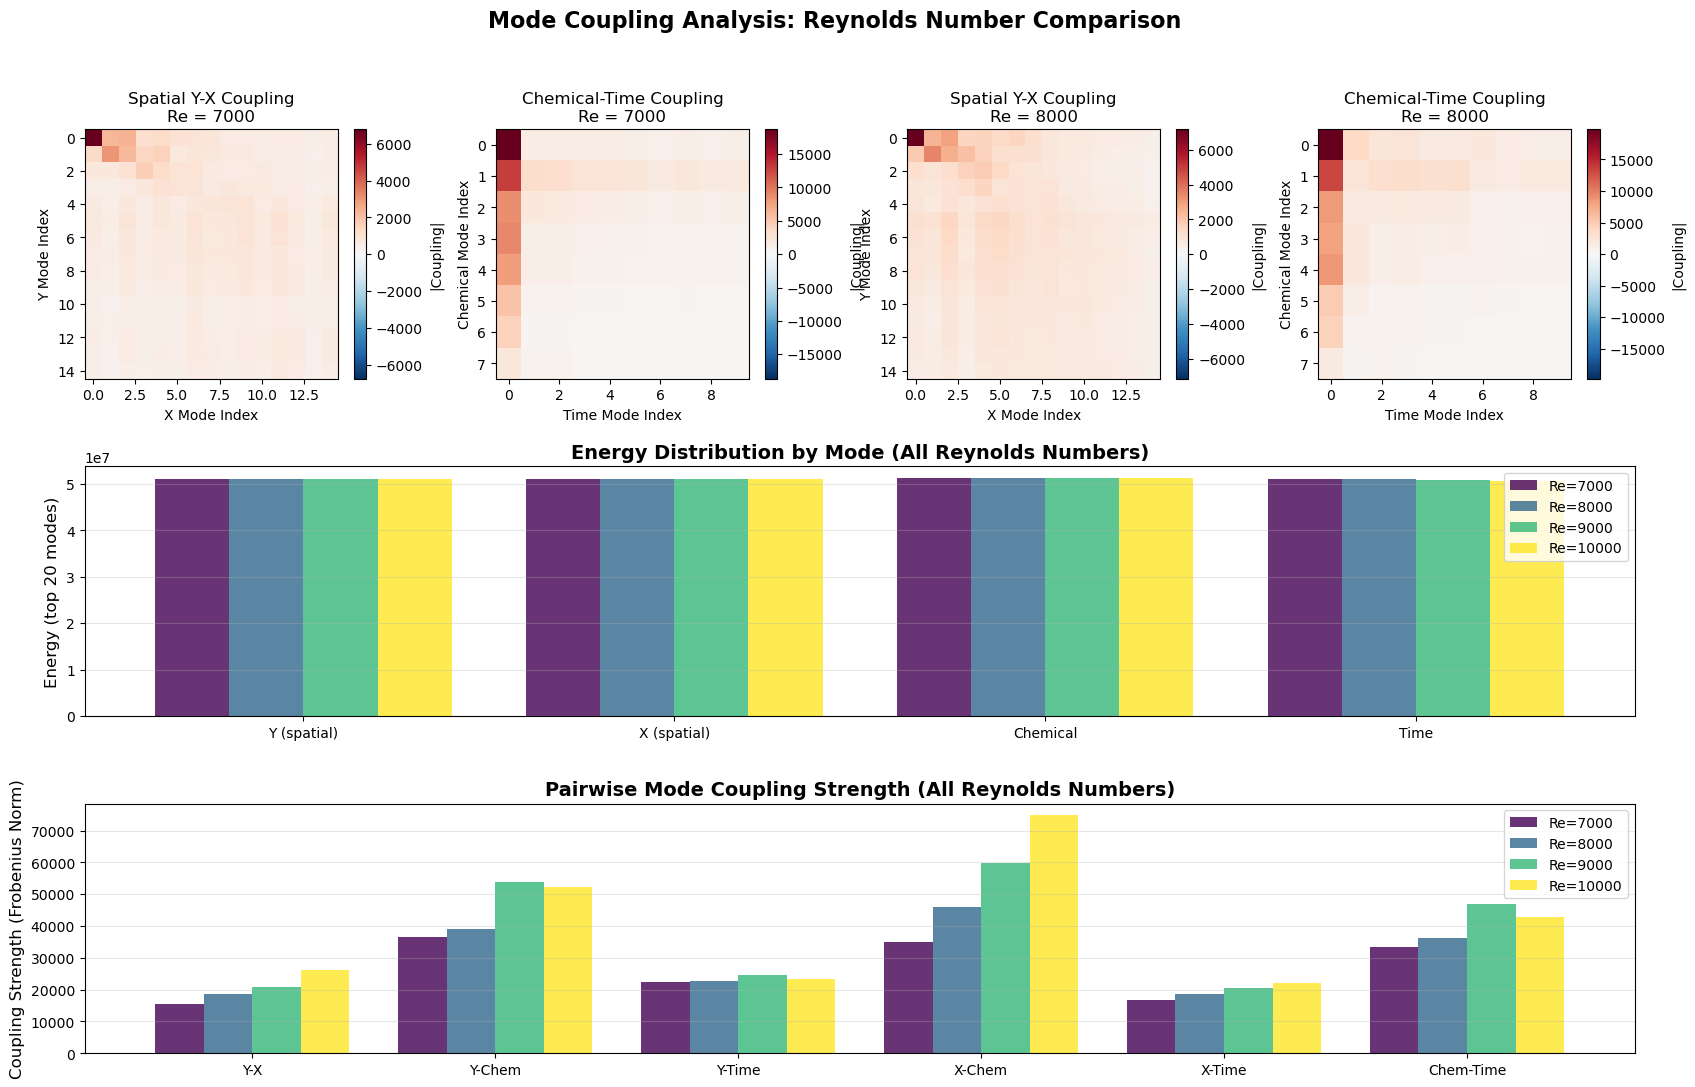


QUANTITATIVE METRICS: REYNOLDS NUMBER COMPARISON

Reynolds Number = 7000:
--------------------------------------------------------------------------------
  Core tensor shape: (200, 160, 8, 200)
  Sparsity (% below 1% of max): 100.00%
  Spatial diagonal dominance: 0.0384

  Energy concentration:
    90% energy in 5 components (0.000%)
    95% energy in 22 components (0.000%)
    99% energy in 795 components (0.002%)

  Effective ranks of mode couplings:
    spatial_y_x: 6.42 (top 10 modes: 99.9% energy)
    spatial_y_chem: 2.04 (top 10 modes: 100.0% energy)
    spatial_y_time: 5.52 (top 10 modes: 99.9% energy)
    spatial_x_chem: 2.85 (top 10 modes: 100.0% energy)
    spatial_x_time: 5.79 (top 10 modes: 99.9% energy)
    chem_time: 2.02 (top 10 modes: 100.0% energy)

Reynolds Number = 8000:
--------------------------------------------------------------------------------
  Core tensor shape: (200, 160, 8, 200)
  Sparsity (% below 1% of max): 100.00%
  Spatial diagonal dominance: 0.0364

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def compute_coupling_metrics(core_tensor):
    """
    Compute various coupling metrics for a core tensor.
    
    Parameters:
    -----------
    core_tensor : ndarray
        The core tensor from HOSVD decomposition
        Shape: (Ny, Nx, n_chem, n_time)
    
    Returns:
    --------
    metrics : dict
        Dictionary containing various coupling metrics
    """
    metrics = {}
    
    # 1. Mode energy distribution (how energy is distributed across each mode)
    for mode_idx in range(core_tensor.ndim):
        mode_energy = np.sum(core_tensor**2, axis=tuple(i for i in range(core_tensor.ndim) if i != mode_idx))
        metrics[f'mode_{mode_idx}_energy'] = mode_energy
        metrics[f'mode_{mode_idx}_energy_ratio'] = mode_energy / np.sum(core_tensor**2)
    
    # 2. Pairwise mode coupling strength (sum over other modes)
    mode_pairs = [(0, 1, 'spatial_y_x'), (0, 2, 'spatial_y_chem'), 
                  (0, 3, 'spatial_y_time'), (1, 2, 'spatial_x_chem'),
                  (1, 3, 'spatial_x_time'), (2, 3, 'chem_time')]
    
    for mode_i, mode_j, name in mode_pairs:
        other_modes = tuple(k for k in range(core_tensor.ndim) if k not in [mode_i, mode_j])
        coupling_matrix = np.sum(np.abs(core_tensor), axis=other_modes)
        metrics[f'coupling_{name}'] = coupling_matrix
        
        # Frobenius norm of coupling matrix
        metrics[f'coupling_{name}_norm'] = np.linalg.norm(coupling_matrix, 'fro')
        
        # Effective rank (using singular values)
        s = np.linalg.svd(coupling_matrix, compute_uv=False)
        s_normalized = s / np.sum(s)
        metrics[f'coupling_{name}_effective_rank'] = np.exp(entropy(s_normalized))
        metrics[f'coupling_{name}_top10_energy'] = np.sum(s[:10]**2) / np.sum(s**2)
    
    # 3. Diagonal dominance (measures separability)
    # For spatial modes (Y, X)
    spatial_slice = np.sum(np.abs(core_tensor), axis=(2, 3))
    diagonal_sum = np.sum(np.diag(spatial_slice[:min(spatial_slice.shape), :min(spatial_slice.shape)]))
    total_sum = np.sum(spatial_slice)
    metrics['spatial_diagonal_dominance'] = diagonal_sum / total_sum
    
    # 4. Sparsity measure (percentage of core elements below threshold)
    threshold = 0.01 * np.max(np.abs(core_tensor))
    metrics['sparsity'] = np.sum(np.abs(core_tensor) < threshold) / core_tensor.size
    
    # 5. Core tensor concentration (what % of energy in top k modes)
    core_flat = np.abs(core_tensor.flatten())
    core_sorted = np.sort(core_flat)[::-1]
    cumsum = np.cumsum(core_sorted**2)
    total_energy = cumsum[-1]
    
    for percentile in [90, 95, 99]:
        idx = np.searchsorted(cumsum, (percentile/100) * total_energy)
        metrics[f'energy_{percentile}%_components'] = idx
        metrics[f'energy_{percentile}%_ratio'] = idx / len(core_flat)
    
    return metrics


def visualize_coupling_comprehensive(decomposition_results, reynolds_numbers, figsize=(20, 12)):
    """
    Create comprehensive visualization of mode coupling across Reynolds numbers.
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.3)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(reynolds_numbers)))
    
    for idx, (re_num, color) in enumerate(zip(reynolds_numbers, colors)):
        key = f"Re{re_num}"
        core = decomposition_results[key]['core']
        metrics = compute_coupling_metrics(core)
        
        col_offset = idx % 2 * 2
        row_offset = idx // 2
        
        if idx >= 2:
            continue  # Only show first 2 Re numbers in detailed view
        
        label = f"Re = {re_num}"
        
        # 1. Spatial coupling (Y-X)
        ax1 = fig.add_subplot(gs[0, col_offset])
        spatial_coupling = metrics['coupling_spatial_y_x'][:15, :15]
        im1 = ax1.imshow(spatial_coupling, cmap='RdBu_r', aspect='auto',
                        vmin=-np.abs(spatial_coupling).max(),
                        vmax=np.abs(spatial_coupling).max())
        ax1.set_xlabel('X Mode Index')
        ax1.set_ylabel('Y Mode Index')
        ax1.set_title(f'Spatial Y-X Coupling\n{label}')
        plt.colorbar(im1, ax=ax1, label='|Coupling|')
        
        # 2. Chemical-Time coupling
        ax2 = fig.add_subplot(gs[0, col_offset+1])
        chem_time_coupling = metrics['coupling_chem_time'][:10, :10]
        im2 = ax2.imshow(chem_time_coupling, cmap='RdBu_r', aspect='auto',
                        vmin=-np.abs(chem_time_coupling).max(),
                        vmax=np.abs(chem_time_coupling).max())
        ax2.set_xlabel('Time Mode Index')
        ax2.set_ylabel('Chemical Mode Index')
        ax2.set_title(f'Chemical-Time Coupling\n{label}')
        plt.colorbar(im2, ax=ax2, label='|Coupling|')
    
    # 3. Mode energy distribution comparison (all Re)
    ax3 = fig.add_subplot(gs[1, :])
    mode_names = ['Y (spatial)', 'X (spatial)', 'Chemical', 'Time']
    x = np.arange(len(mode_names))
    width = 0.8 / len(reynolds_numbers)
    
    for idx, (re_num, color) in enumerate(zip(reynolds_numbers, colors)):
        key = f"Re{re_num}"
        metrics = compute_coupling_metrics(decomposition_results[key]['core'])
        mode_energies = [np.sum(metrics[f'mode_{i}_energy'][:20]) for i in range(4)]
        
        offset = (idx - len(reynolds_numbers)/2) * width + width/2
        bars = ax3.bar(x + offset, mode_energies, width, label=f'Re={re_num}', color=color, alpha=0.8)
    
    ax3.set_ylabel('Energy (top 20 modes)', fontsize=12)
    ax3.set_title('Energy Distribution by Mode (All Reynolds Numbers)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(mode_names)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Coupling strength comparison (all Re)
    ax4 = fig.add_subplot(gs[2, :])
    coupling_names = ['Y-X', 'Y-Chem', 'Y-Time', 'X-Chem', 'X-Time', 'Chem-Time']
    coupling_keys = ['spatial_y_x', 'spatial_y_chem', 'spatial_y_time', 
                   'spatial_x_chem', 'spatial_x_time', 'chem_time']
    x = np.arange(len(coupling_names))
    width = 0.8 / len(reynolds_numbers)
    
    for idx, (re_num, color) in enumerate(zip(reynolds_numbers, colors)):
        key = f"Re{re_num}"
        metrics = compute_coupling_metrics(decomposition_results[key]['core'])
        coupling_strengths = [metrics[f'coupling_{key}_norm'] for key in coupling_keys]
        
        offset = (idx - len(reynolds_numbers)/2) * width + width/2
        bars = ax4.bar(x + offset, coupling_strengths, width, label=f'Re={re_num}', color=color, alpha=0.8)
    
    ax4.set_ylabel('Coupling Strength (Frobenius Norm)', fontsize=12)
    ax4.set_title('Pairwise Mode Coupling Strength (All Reynolds Numbers)', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(coupling_names)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    fig.suptitle('Mode Coupling Analysis: Reynolds Number Comparison', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    # Print quantitative metrics
    print("\n" + "="*100)
    print("QUANTITATIVE METRICS: REYNOLDS NUMBER COMPARISON")
    print("="*100)
    
    for re_num in reynolds_numbers:
        key = f"Re{re_num}"
        core = decomposition_results[key]['core']
        metrics = compute_coupling_metrics(core)
        
        print(f"\nReynolds Number = {re_num}:")
        print("-" * 80)
        print(f"  Core tensor shape: {core.shape}")
        print(f"  Sparsity (% below 1% of max): {metrics['sparsity']*100:.2f}%")
        print(f"  Spatial diagonal dominance: {metrics['spatial_diagonal_dominance']:.4f}")
        print(f"\n  Energy concentration:")
        print(f"    90% energy in {metrics['energy_90%_components']} components ({metrics['energy_90%_ratio']*100:.3f}%)")
        print(f"    95% energy in {metrics['energy_95%_components']} components ({metrics['energy_95%_ratio']*100:.3f}%)")
        print(f"    99% energy in {metrics['energy_99%_components']} components ({metrics['energy_99%_ratio']*100:.3f}%)")
        
        print(f"\n  Effective ranks of mode couplings:")
        for coupling_key in ['spatial_y_x', 'spatial_y_chem', 'spatial_y_time', 
                   'spatial_x_chem', 'spatial_x_time', 'chem_time']:
            print(f"    {coupling_key}: {metrics[f'coupling_{coupling_key}_effective_rank']:.2f} " +
                  f"(top 10 modes: {metrics[f'coupling_{coupling_key}_top10_energy']*100:.1f}% energy)")


# Run the comprehensive coupling analysis
print("Computing coupling metrics and creating visualizations...")
visualize_coupling_comprehensive(decomposition_results, reynolds_numbers)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def select_top_modes_by_coupling(values, energy_threshold=0.99):
    """
    Select modes based on top coupling values that capture desired energy.
    
    Parameters:
    -----------
    values : ndarray
        Values to analyze (e.g., one column of coupling matrix)
    energy_threshold : float
        Fraction of energy to retain
    
    Returns:
    --------
    selected_indices : ndarray
        Indices of selected modes (sorted by importance)
    n_modes : int
        Number of modes to keep
    cumulative_energy : ndarray
        Cumulative energy fraction (for the sorted modes)
    """
    energy = values**2
    total_energy = np.sum(energy)
    if total_energy == 0:
        return np.array([0]), 1, np.array([0])
    
    # Sort by energy (descending) and get indices
    sorted_indices = np.argsort(energy)[::-1]
    sorted_energy = energy[sorted_indices]
    
    # Find how many top modes we need
    cumulative_energy = np.cumsum(sorted_energy) / total_energy
    n_modes = np.searchsorted(cumulative_energy, energy_threshold) + 1
    n_modes = min(n_modes, len(values))
    
    # Return the indices of the selected modes
    selected_indices = sorted_indices[:n_modes]
    
    return selected_indices, n_modes, cumulative_energy


# Main analysis
energy_threshold = 0.99
species_names = ['H', 'H2', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2']

# Store all results for visualization
analysis_results = {}

for i in range(len(reynolds_numbers)):
    re = reynolds_numbers[i]
    key = f"Re{re}"
    
    # Get decomposition components
    core = decomposition_results[key]['core']
    U_y = decomposition_results[key]['U_y']
    U_x = decomposition_results[key]['U_x']
    U_chem = decomposition_results[key]['U_chem']
    U_time = decomposition_results[key]['U_time']
    
    original = tensors_scaled[key]
    n_chem = core.shape[2]
    
    # ============================================
    # COMPUTE COUPLING MATRICES
    # ============================================
    
    coupling_chem_x = np.sum(np.abs(core), axis=(0, 3))  # [x, chem]
    
    coupling_chem_y = np.sum(np.abs(core), axis=(1, 3))  # [y, chem]
    
    coupling_chem_t = np.sum(np.abs(core), axis=(0, 1))  # [chem, time]
    
    # ============================================
    # ENERGY-BASED TRUNCATION FOR EACH CHEMISTRY MODE
    # (Now selecting top modes by coupling strength)
    # ============================================
    
    modes_x_per_chem = []
    modes_y_per_chem = []
    modes_t_per_chem = []
    
    indices_x_per_chem = []
    indices_y_per_chem = []
    indices_t_per_chem = []
    
    cum_energy_x_per_chem = []
    cum_energy_y_per_chem = []
    cum_energy_t_per_chem = []
    
    print(f"\n{'='*80}")
    print(f"Re = {re} | Energy-based truncation at {energy_threshold:.0%}")
    print(f"(Selecting top modes by coupling strength)")
    print(f"{'='*80}")
    print(f"{'PCs':8s} | {'X modes':8s} | {'Y modes':8s} | {'T modes':8s}")
    print(f"{'-'*80}")
    
    for chem_idx in range(n_chem):
        species = f"PC {chem_idx}"
        
        # For X: look at column chem_idx in coupling_chem_x
        indices_x, n_modes_x, cum_energy_x = select_top_modes_by_coupling(
            coupling_chem_x[:, chem_idx], energy_threshold
        )
        modes_x_per_chem.append(n_modes_x)
        indices_x_per_chem.append(indices_x)
        cum_energy_x_per_chem.append(cum_energy_x)
        
        # For Y: look at column chem_idx in coupling_chem_y
        indices_y, n_modes_y, cum_energy_y = select_top_modes_by_coupling(
            coupling_chem_y[:, chem_idx], energy_threshold
        )
        modes_y_per_chem.append(n_modes_y)
        indices_y_per_chem.append(indices_y)
        cum_energy_y_per_chem.append(cum_energy_y)
        
        # For Time: look at row chem_idx in coupling_chem_t
        indices_t, n_modes_t, cum_energy_t = select_top_modes_by_coupling(
            coupling_chem_t[chem_idx, :], energy_threshold
        )
        modes_t_per_chem.append(n_modes_t)
        indices_t_per_chem.append(indices_t)
        cum_energy_t_per_chem.append(cum_energy_t)
        
        print(f"{species:8s} | {n_modes_x:8d} | {n_modes_y:8d} | {n_modes_t:8d}")
    
    # ============================================
    # COMPUTE RECONSTRUCTIONS FOR FOCUS SPECIES (OH)
    # ============================================
    
    focus_idx = 0
    focus_species = species_names[focus_idx]
    time_idx = 0
    
    # Get optimal modes for focus species
    indices_x_focus = indices_x_per_chem[focus_idx]
    indices_y_focus = indices_y_per_chem[focus_idx]
    indices_t_focus = indices_t_per_chem[focus_idx]
    
    n_modes_x_focus = len(indices_x_focus)
    n_modes_y_focus = len(indices_y_focus)
    n_modes_t_focus = len(indices_t_focus)
    
    # Reconstruct with X truncation (selecting specific modes)
    core_truncated_x = core[:, indices_x_focus, :, :]
    U_x_truncated = U_x[:, indices_x_focus]
    reconst_x = multi_mode_dot(
        core_truncated_x,
        [U_y, U_x_truncated, U_chem, U_time],
        modes=[0, 1, 2, 3]
    )
    
    # Reconstruct with Y truncation (selecting specific modes)
    core_truncated_y = core[indices_y_focus, :, :, :]
    U_y_truncated = U_y[:, indices_y_focus]
    reconst_y = multi_mode_dot(
        core_truncated_y,
        [U_y_truncated, U_x, U_chem, U_time],
        modes=[0, 1, 2, 3]
    )
    
    # Reconstruct with Time truncation (selecting specific modes)
    core_truncated_t = core[:, :, :, indices_t_focus]
    U_time_truncated = U_time[:, indices_t_focus]
    reconst_t = multi_mode_dot(
        core_truncated_t,
        [U_y, U_x, U_chem, U_time_truncated],
        modes=[0, 1, 2, 3]
    )
    
    # Compute reconstruction errors
    original_slice = original[:, :, focus_idx, time_idx]
    
    reconst_slice_x = reconst_x[:, :, focus_idx, time_idx]
    error_x = np.linalg.norm(original_slice - reconst_slice_x) / np.linalg.norm(original_slice)
    
    reconst_slice_y = reconst_y[:, :, focus_idx, time_idx]
    error_y = np.linalg.norm(original_slice - reconst_slice_y) / np.linalg.norm(original_slice)
    
    reconst_slice_t = reconst_t[:, :, focus_idx, time_idx]
    error_t = np.linalg.norm(original_slice - reconst_slice_t) / np.linalg.norm(original_slice)
    
    print(f"\n{focus_species} Reconstruction Errors:")
    print(f"  X-truncation ({n_modes_x_focus} modes): {error_x:.6f}")
    print(f"  Y-truncation ({n_modes_y_focus} modes): {error_y:.6f}")
    print(f"  T-truncation ({n_modes_t_focus} modes): {error_t:.6f}")
    
    # ============================================
    # STORE RESULTS FOR VISUALIZATION
    # ============================================
    
    analysis_results[key] = {
        'coupling_chem_x': coupling_chem_x,
        'coupling_chem_y': coupling_chem_y,
        'coupling_chem_t': coupling_chem_t,
        'modes_x_per_chem': modes_x_per_chem,
        'modes_y_per_chem': modes_y_per_chem,
        'modes_t_per_chem': modes_t_per_chem,
        'indices_x_per_chem': indices_x_per_chem,
        'indices_y_per_chem': indices_y_per_chem,
        'indices_t_per_chem': indices_t_per_chem,
        'cum_energy_x_per_chem': cum_energy_x_per_chem,
        'cum_energy_y_per_chem': cum_energy_y_per_chem,
        'cum_energy_t_per_chem': cum_energy_t_per_chem,
        'focus_idx': focus_idx,
        'focus_species': focus_species,
        'time_idx': time_idx,
        'original_slice': original_slice,
        'reconst_slice_x': reconst_slice_x,
        'reconst_slice_y': reconst_slice_y,
        'reconst_slice_t': reconst_slice_t,
        'error_x': error_x,
        'error_y': error_y,
        'error_t': error_t,
        'n_modes_x_focus': n_modes_x_focus,
        'n_modes_y_focus': n_modes_y_focus,
        'n_modes_t_focus': n_modes_t_focus,
    }

print(f"\n{'='*80}")
print("Analysis complete. Results stored in 'analysis_results' dictionary.")
print(f"{'='*80}")


Re = 7000 | Energy-based truncation at 99%
(Selecting top modes by coupling strength)
PCs      | X modes  | Y modes  | T modes 
--------------------------------------------------------------------------------
PC 0     |       51 |       47 |      118
PC 1     |       54 |       47 |      158
PC 2     |       56 |       47 |      152
PC 3     |       57 |       51 |      144
PC 4     |       58 |       61 |      176
PC 5     |       66 |       53 |      137
PC 6     |       64 |       76 |      170
PC 7     |       60 |       73 |      190

H Reconstruction Errors:
  X-truncation (51 modes): 0.006021
  Y-truncation (47 modes): 0.002891
  T-truncation (118 modes): 0.003532

Re = 8000 | Energy-based truncation at 99%
(Selecting top modes by coupling strength)
PCs      | X modes  | Y modes  | T modes 
--------------------------------------------------------------------------------
PC 0     |       41 |       62 |      128
PC 1     |       44 |       56 |      160
PC 2     |       47 |    

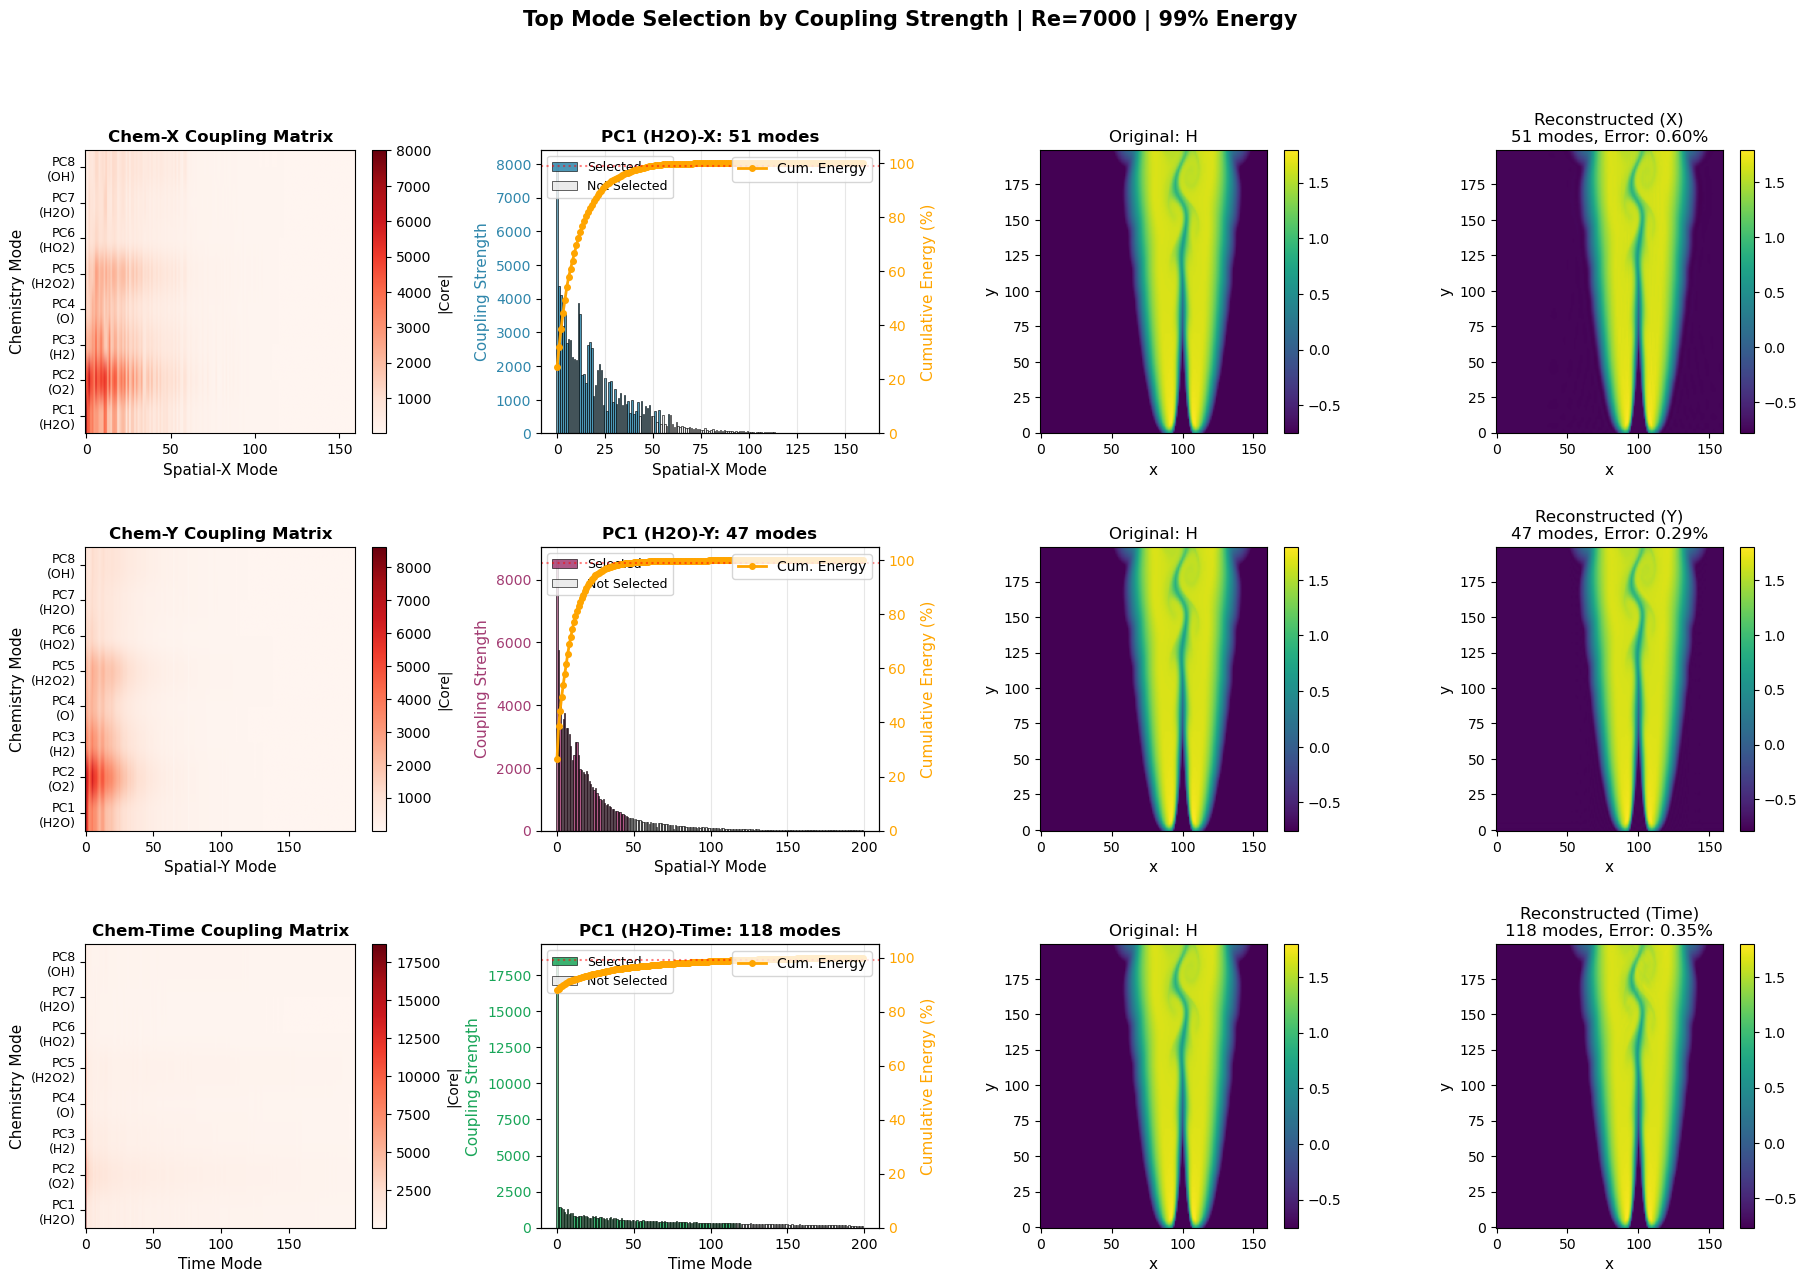


Chemistry Mode Composition for Re = 7000
Mode     | Dominant | Top 3 Contributing Species
--------------------------------------------------------------------------------
PC 1    | H2O      | H2O(0.38), H(0.38), OH(0.38)
PC 2    | O2       | O2(0.84), H2(0.31), O(0.27)
PC 3    | H2       | H2(0.73), HO2(0.42), O2(0.35)
PC 4    | O        | O(0.55), H(0.48), OH(0.37)
PC 5    | H2O2     | H2O2(0.75), H2O(0.48), H2(0.27)
PC 6    | HO2      | HO2(0.65), H(0.60), O2(0.34)
PC 7    | H2O      | H2O(0.76), H(0.43), O(0.27)
PC 8    | OH       | OH(0.78), O(0.62), H(0.08)

Selected Mode Indices for Re = 7000 (Focus: PC1 - H)
X modes selected: [np.int64(0), np.int64(1), np.int64(2), np.int64(11), np.int64(12), np.int64(4), np.int64(3), np.int64(6), np.int64(7), np.int64(17), np.int64(5), np.int64(16), np.int64(18), np.int64(8), np.int64(9), np.int64(10), np.int64(22), np.int64(23), np.int64(21), np.int64(14), np.int64(13), np.int64(25), np.int64(28), np.int64(27), np.int64(15), np.int64(20), np.

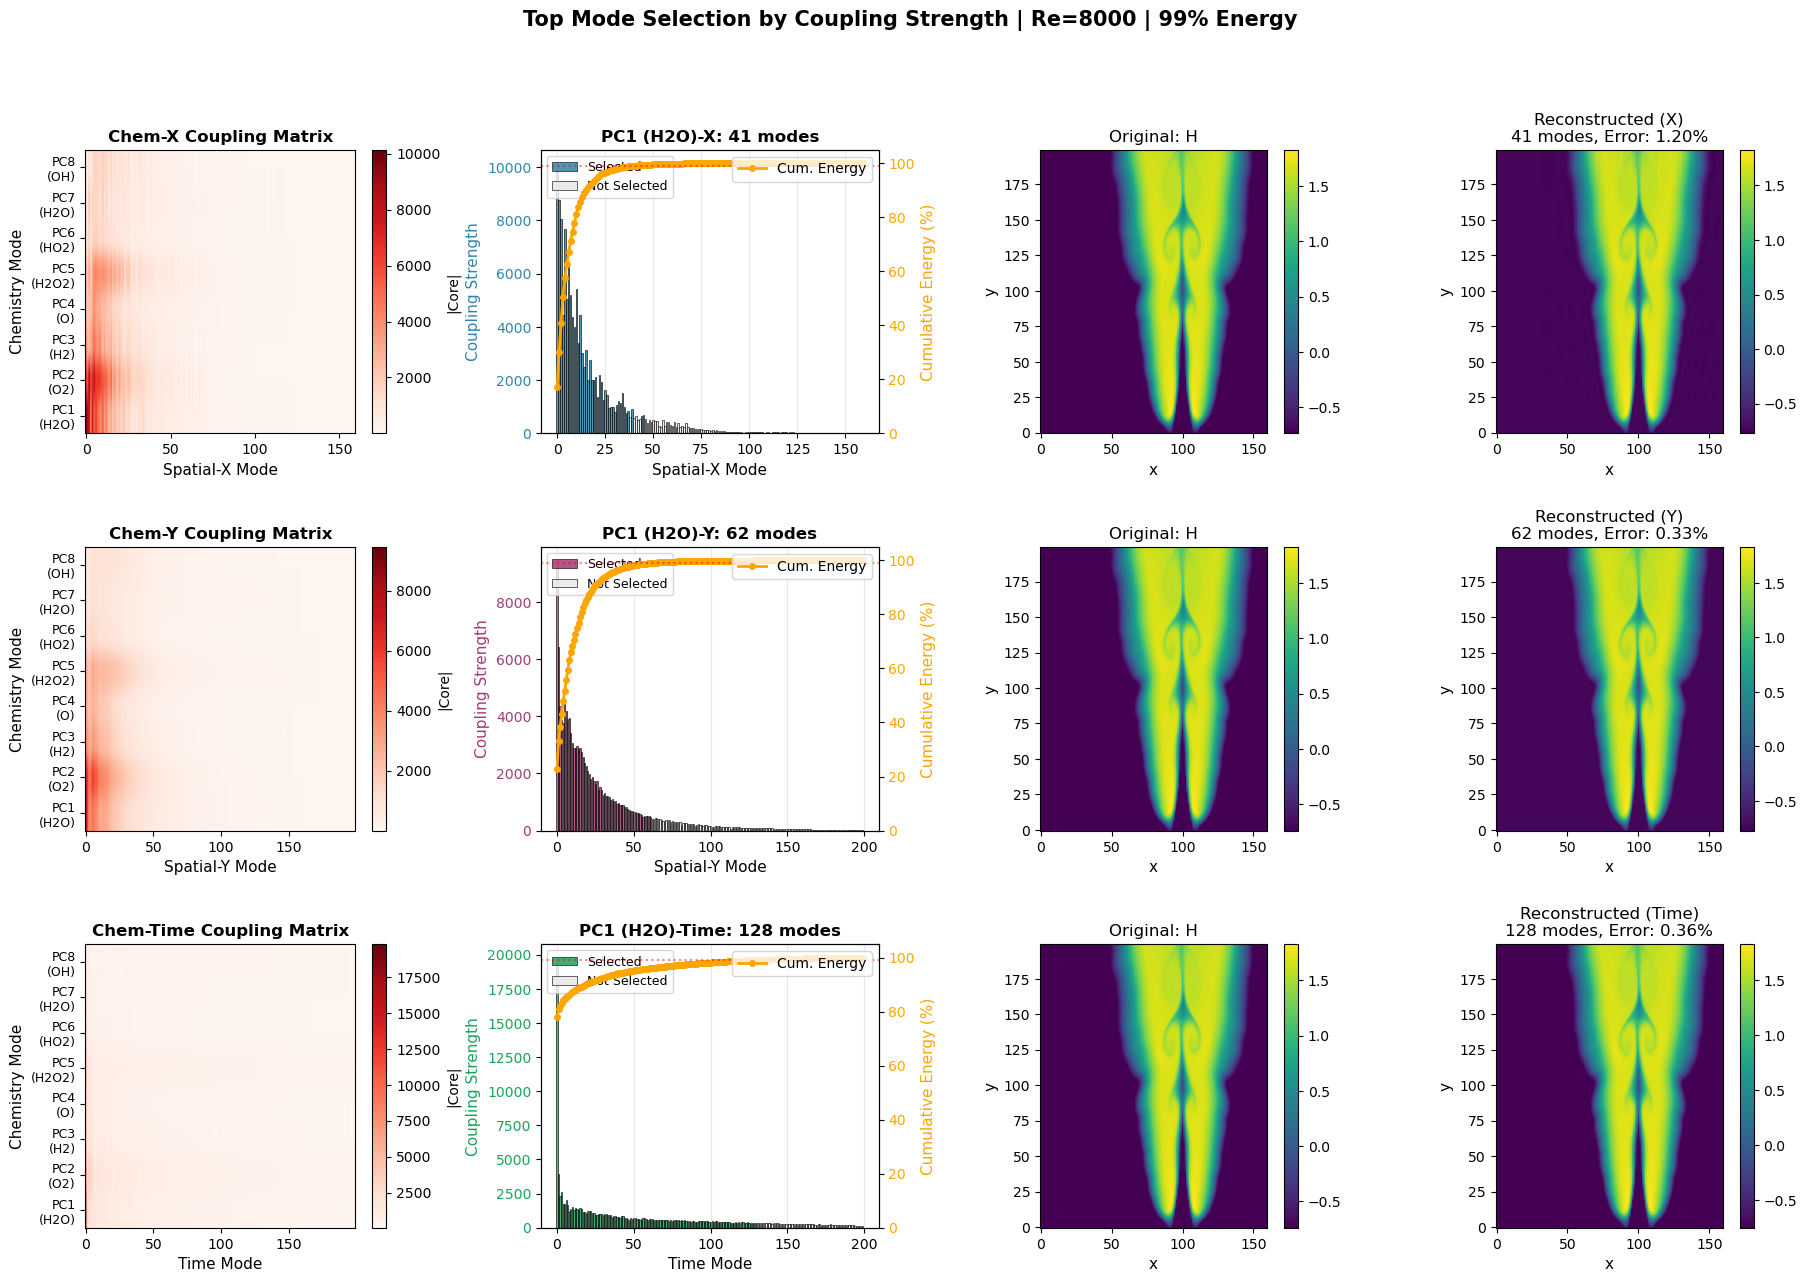


Chemistry Mode Composition for Re = 8000
Mode     | Dominant | Top 3 Contributing Species
--------------------------------------------------------------------------------
PC 1    | H2O      | H2O(0.38), OH(0.38), H(0.38)
PC 2    | O2       | O2(0.84), H2(0.33), O(0.26)
PC 3    | H2       | H2(0.77), O2(0.36), HO2(0.34)
PC 4    | O        | O(0.58), H(0.49), HO2(0.43)
PC 5    | H2O2     | H2O2(0.79), H2O(0.46), HO2(0.24)
PC 6    | HO2      | HO2(0.67), H(0.57), O2(0.34)
PC 7    | H2O      | H2O(0.76), H(0.47), O(0.28)
PC 8    | OH       | OH(0.78), O(0.61), H2O(0.10)

Selected Mode Indices for Re = 8000 (Focus: PC1 - H)
X modes selected: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(6), np.int64(10), np.int64(7), np.int64(5), np.int64(3), np.int64(12), np.int64(8), np.int64(9), np.int64(11), np.int64(15), np.int64(13), np.int64(17), np.int64(14), np.int64(22), np.int64(20), np.int64(18), np.int64(19), np.int64(16), np.int64(23), np.int64(25), np.int64(34), np.int64(26),

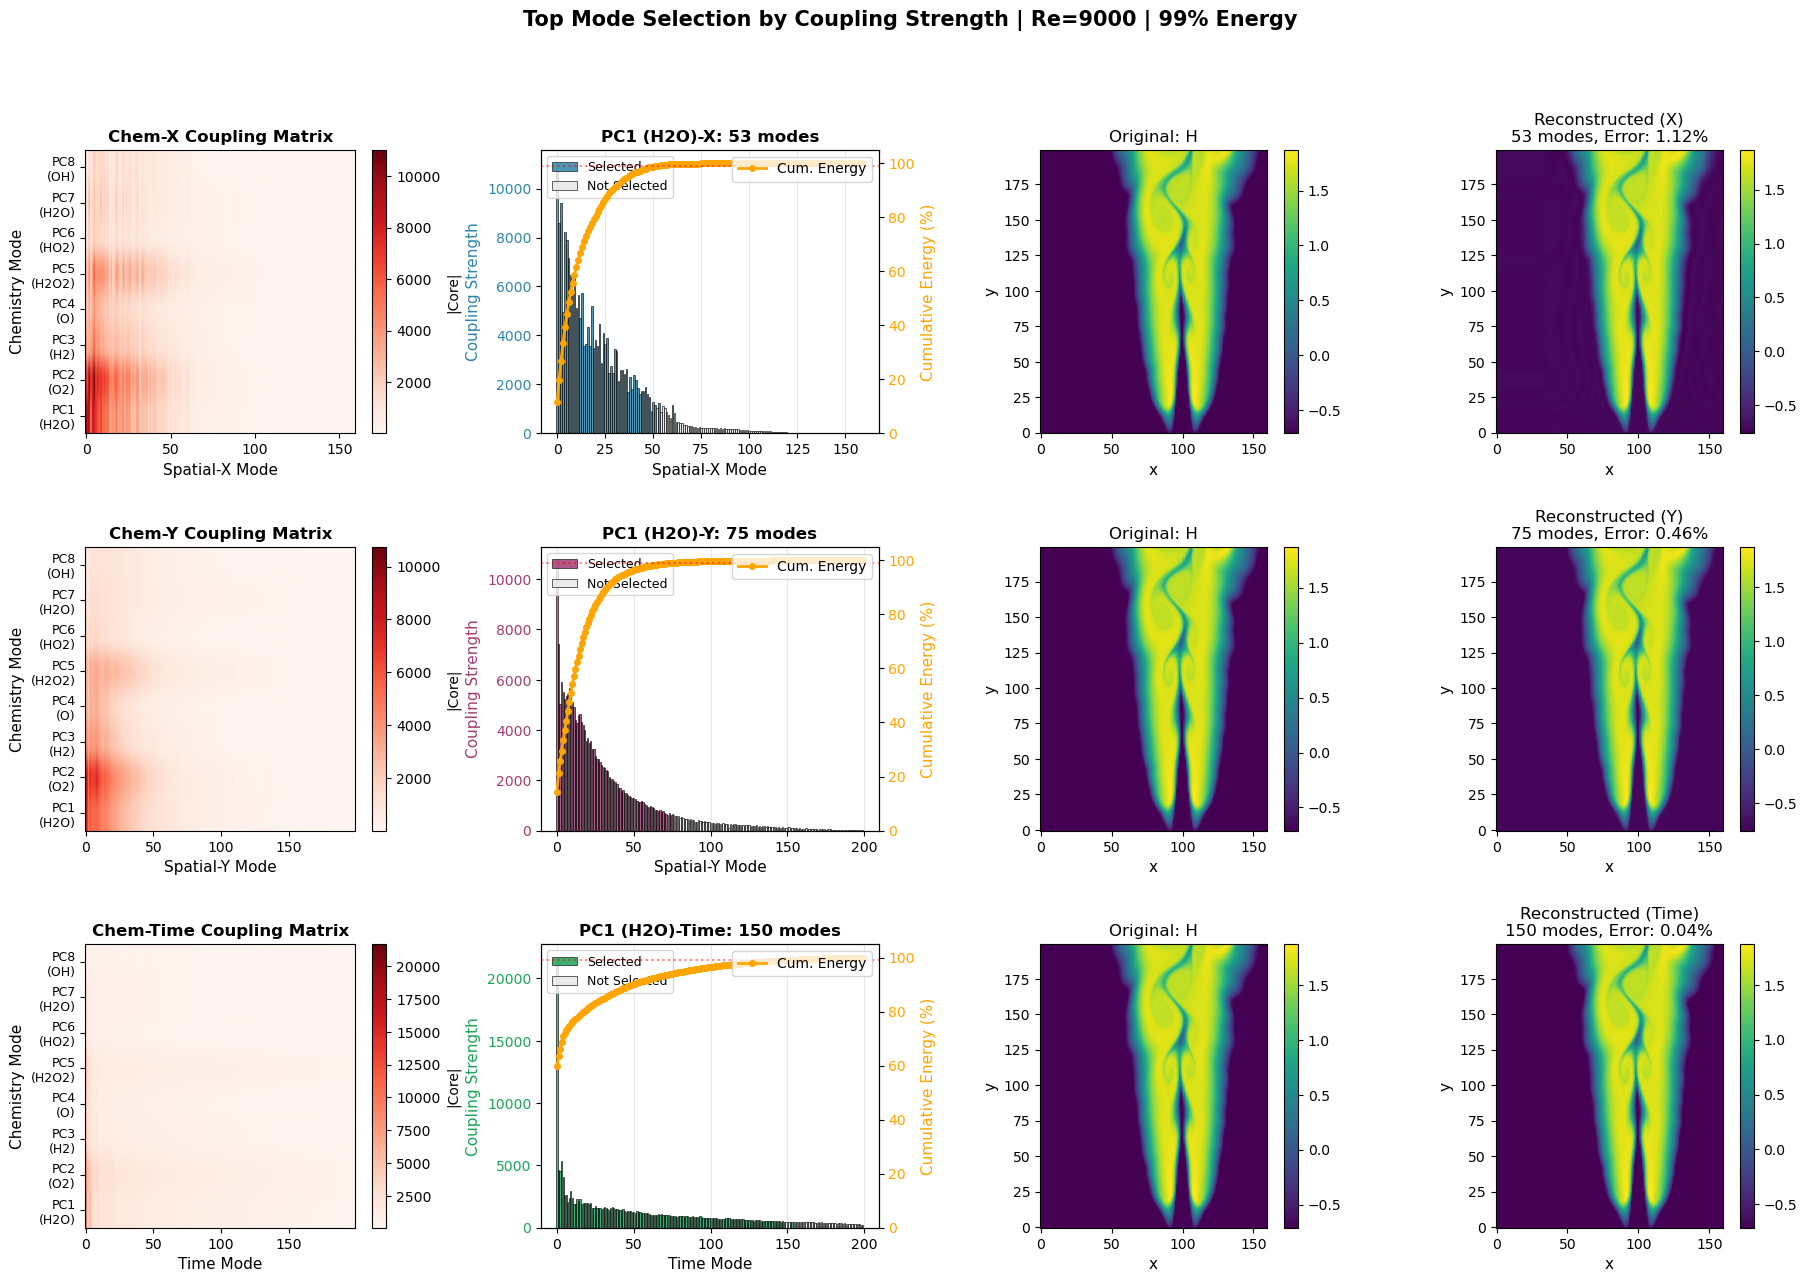


Chemistry Mode Composition for Re = 9000
Mode     | Dominant | Top 3 Contributing Species
--------------------------------------------------------------------------------
PC 1    | H2O      | H2O(0.38), OH(0.38), H(0.38)
PC 2    | O2       | O2(0.84), H2(0.34), O(0.25)
PC 3    | H2       | H2(0.79), O2(0.38), HO2(0.29)
PC 4    | O        | O(0.59), H(0.51), HO2(0.44)
PC 5    | H2O2     | H2O2(0.83), H2O(0.43), H2(0.19)
PC 6    | HO2      | HO2(0.71), H(0.53), O2(0.31)
PC 7    | H2O      | H2O(0.77), H(0.50), O(0.27)
PC 8    | OH       | OH(0.78), O(0.61), H2O(0.11)

Selected Mode Indices for Re = 9000 (Focus: PC1 - H)
X modes selected: [np.int64(0), np.int64(2), np.int64(1), np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(7), np.int64(8), np.int64(13), np.int64(11), np.int64(18), np.int64(10), np.int64(3), np.int64(12), np.int64(22), np.int64(16), np.int64(24), np.int64(26), np.int64(20), np.int64(15), np.int64(25), np.int64(14), np.int64(21), np.int64(17), np.int64(19), 

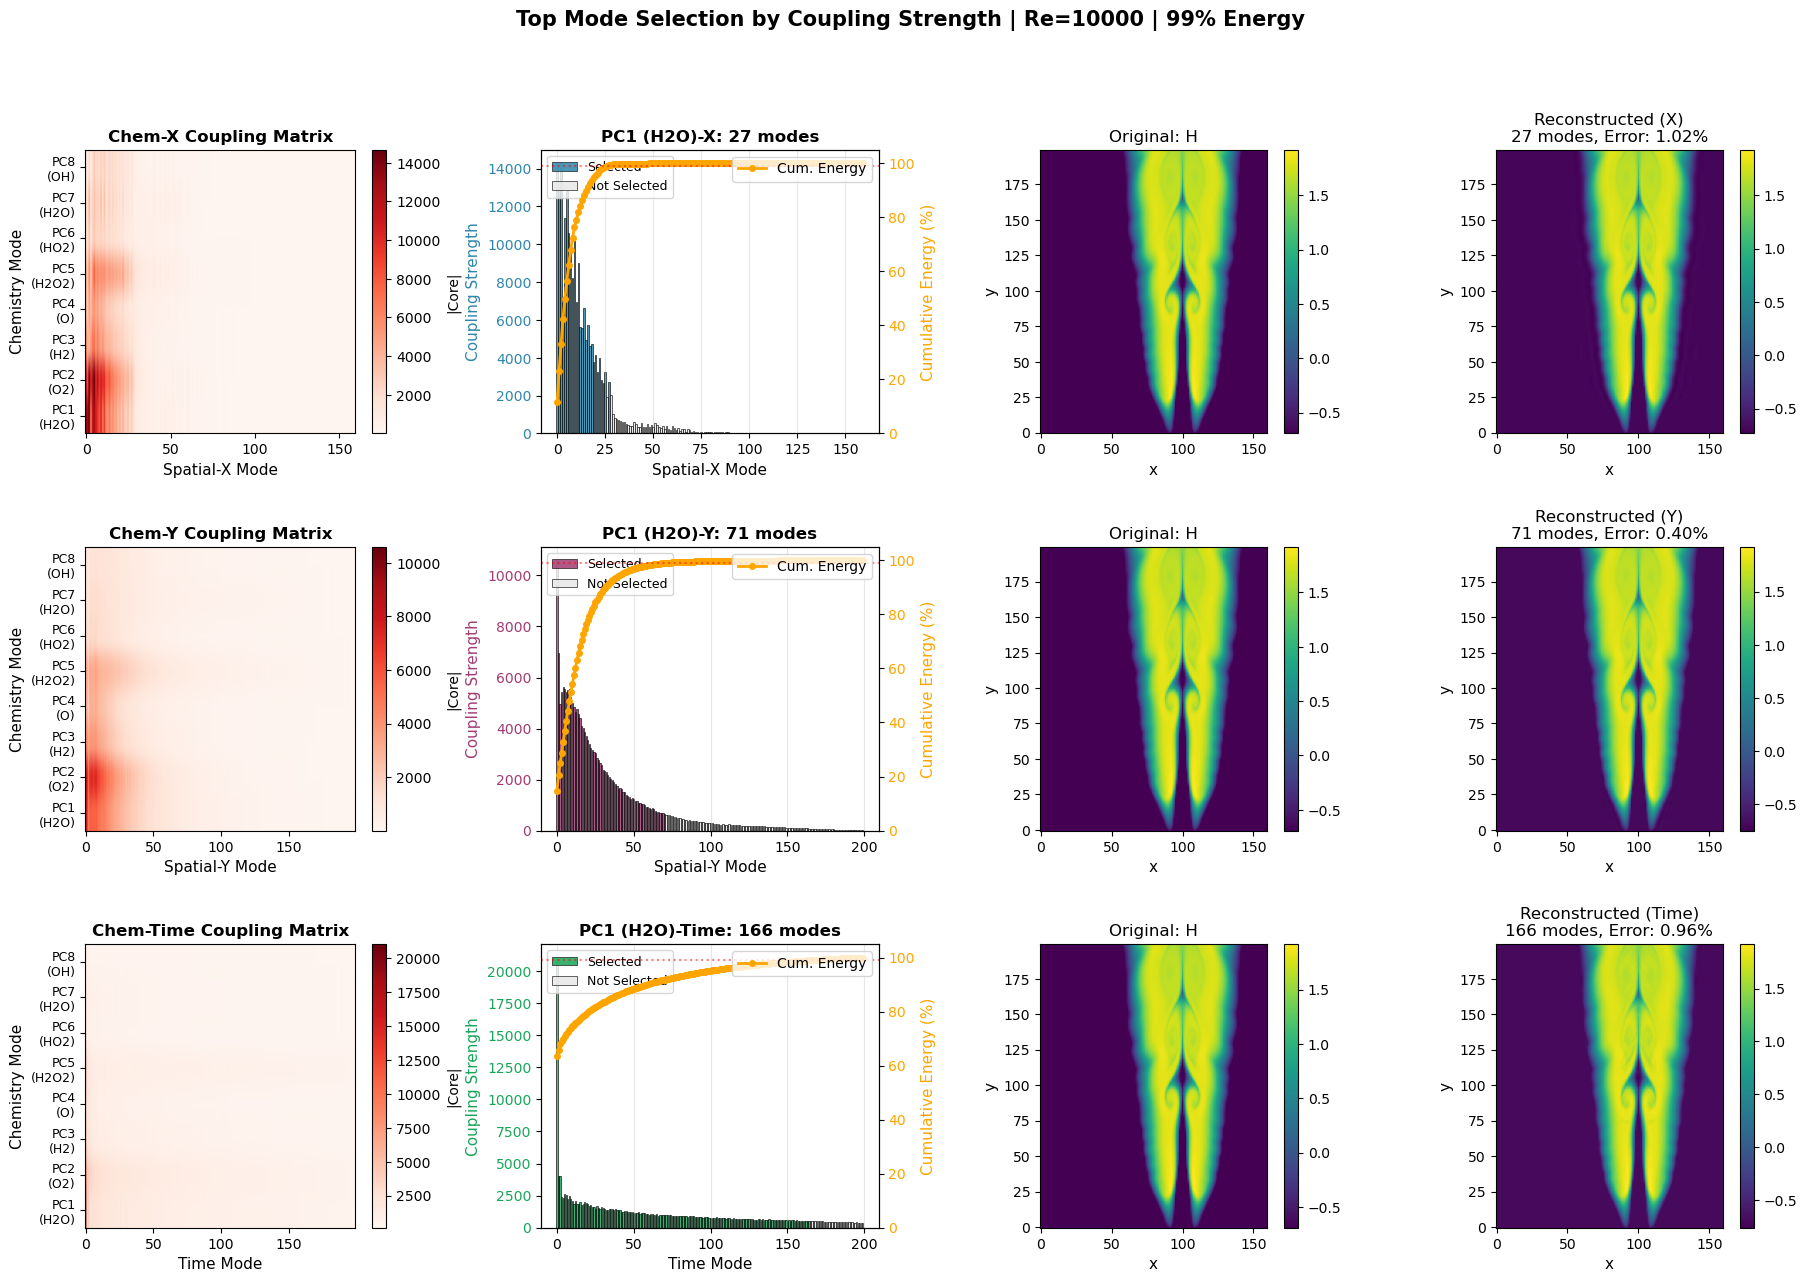


Chemistry Mode Composition for Re = 10000
Mode     | Dominant | Top 3 Contributing Species
--------------------------------------------------------------------------------
PC 1    | H2O      | H2O(0.38), H(0.38), OH(0.38)
PC 2    | O2       | O2(0.84), H2(0.35), O(0.24)
PC 3    | H2       | H2(0.80), O2(0.39), HO2(0.28)
PC 4    | O        | O(0.59), H(0.51), HO2(0.44)
PC 5    | H2O2     | H2O2(0.84), H2O(0.40), OH(0.20)
PC 6    | HO2      | HO2(0.73), H(0.51), O2(0.30)
PC 7    | H2O      | H2O(0.77), H(0.52), O(0.28)
PC 8    | OH       | OH(0.79), O(0.59), H2O(0.14)

Selected Mode Indices for Re = 10000 (Focus: PC1 - H)
X modes selected: [np.int64(2), np.int64(0), np.int64(1), np.int64(5), np.int64(4), np.int64(6), np.int64(9), np.int64(7), np.int64(11), np.int64(8), np.int64(10), np.int64(3), np.int64(14), np.int64(16), np.int64(12), np.int64(13), np.int64(15), np.int64(18), np.int64(17), np.int64(20), np.int64(22), np.int64(19), np.int64(25), np.int64(21), np.int64(23), np.int64(27)

In [15]:
# ============================================
# VISUALIZATION OF ANALYSIS RESULTS (WITH HIGHLIGHTED SELECTED MODES)
# ============================================

for i in range(len(reynolds_numbers)):
    re = reynolds_numbers[i]
    key = f"Re{re}"
    
    results = analysis_results[key]
    
    coupling_chem_x = results['coupling_chem_x']
    coupling_chem_y = results['coupling_chem_y']
    coupling_chem_t = results['coupling_chem_t']
    
    modes_x_per_chem = results['modes_x_per_chem']
    modes_y_per_chem = results['modes_y_per_chem']
    modes_t_per_chem = results['modes_t_per_chem']
    
    indices_x_per_chem = results['indices_x_per_chem']
    indices_y_per_chem = results['indices_y_per_chem']
    indices_t_per_chem = results['indices_t_per_chem']
    
    cum_energy_x_per_chem = results['cum_energy_x_per_chem']
    cum_energy_y_per_chem = results['cum_energy_y_per_chem']
    cum_energy_t_per_chem = results['cum_energy_t_per_chem']
    
    focus_idx = results['focus_idx']
    focus_species = results['focus_species']
    
    original_slice = results['original_slice']
    reconst_slice_x = results['reconst_slice_x']
    reconst_slice_y = results['reconst_slice_y']
    reconst_slice_t = results['reconst_slice_t']
    
    error_x = results['error_x']
    error_y = results['error_y']
    error_t = results['error_t']
    
    n_modes_x_focus = results['n_modes_x_focus']
    n_modes_y_focus = results['n_modes_y_focus']
    n_modes_t_focus = results['n_modes_t_focus']
    
    n_chem = len(species_names)
    
    # ============================================
    # IDENTIFY DOMINANT SPECIES FOR EACH CHEMISTRY MODE
    # ============================================
    # Get U_chem to see which species dominate each mode
    U_chem = decomposition_results[key]['U_chem']
    
    # For each chemistry mode, find dominant species
    dominant_species = []
    for mode_idx in range(n_chem):
        # Get loadings for this mode
        loadings = np.abs(U_chem[:, mode_idx])
        dominant_idx = np.argmax(loadings)
        dominant_species.append(species_names[dominant_idx])
    
    # Create labels: "PC1 (H2)", "PC2 (OH)", etc.
    mode_labels = [f'PC{i+1}\n({dominant_species[i]})' for i in range(n_chem)]
    mode_labels_short = [f'PC{i+1}' for i in range(n_chem)]
    
    # ============================================
    # CREATE FIGURE
    # ============================================
    
    fig = plt.figure(figsize=(22, 14))
    gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.35)
    
    # ----- ROW 1: Chemistry-X Coupling -----
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(coupling_chem_x.T, aspect='auto', cmap='Reds', origin='lower')
    ax1.set_xlabel('Spatial-X Mode', fontsize=11)
    ax1.set_ylabel('Chemistry Mode', fontsize=11)
    ax1.set_yticks(range(n_chem))
    ax1.set_yticklabels(mode_labels, fontsize=9)
    ax1.set_title('Chem-X Coupling Matrix', fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=ax1, label='|Core|')
    
    ax2 = fig.add_subplot(gs[0, 1])
    coupling_col = coupling_chem_x[:, focus_idx]
    cum_energy_x_focus = cum_energy_x_per_chem[focus_idx]
    indices_x_focus = indices_x_per_chem[focus_idx]
    
    # Create color array for bars - more appealing colors
    colors_x = ['#E8E8E8' if i not in indices_x_focus else '#2E86AB' 
                for i in range(len(coupling_col))]
    
    ax2_twin = ax2.twinx()
    ax2.bar(range(len(coupling_col)), coupling_col, alpha=0.85, color=colors_x, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Spatial-X Mode', fontsize=11)
    ax2.set_ylabel('Coupling Strength', fontsize=11, color='#2E86AB')
    ax2.tick_params(axis='y', labelcolor='#2E86AB')
    
    # Add custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2E86AB', alpha=0.85, label='Selected', edgecolor='black', linewidth=0.5),
                      Patch(facecolor='#E8E8E8', alpha=0.85, label='Not Selected', edgecolor='black', linewidth=0.5)]
    ax2.legend(handles=legend_elements, loc='upper left', fontsize=9)
    
    ax2_twin.plot(range(len(cum_energy_x_focus)), cum_energy_x_focus * 100, 
                  'o-', color='orange', linewidth=2, markersize=4, label='Cum. Energy')
    ax2_twin.axhline(energy_threshold * 100, color='red', linestyle=':', alpha=0.5)
    ax2_twin.set_ylabel('Cumulative Energy (%)', fontsize=11, color='orange')
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    ax2_twin.set_ylim([0, 105])
    ax2_twin.legend(loc='upper right')
    
    ax2.set_title(f'PC{focus_idx+1} ({dominant_species[focus_idx]})-X: {n_modes_x_focus} modes', 
                  fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(original_slice, cmap='viridis', origin='lower')
    ax3.set_title(f'Original: {focus_species}', fontsize=12)
    ax3.set_xlabel('x', fontsize=11)
    ax3.set_ylabel('y', fontsize=11)
    plt.colorbar(im3, ax=ax3)
    
    ax4 = fig.add_subplot(gs[0, 3])
    im4 = ax4.imshow(reconst_slice_x, cmap='viridis', origin='lower')
    ax4.set_title(f'Reconstructed (X)\n{n_modes_x_focus} modes, Error: {error_x:.2%}', 
                  fontsize=12)
    ax4.set_xlabel('x', fontsize=11)
    ax4.set_ylabel('y', fontsize=11)
    plt.colorbar(im4, ax=ax4)
    
    # ----- ROW 2: Chemistry-Y Coupling -----
    ax5 = fig.add_subplot(gs[1, 0])
    im5 = ax5.imshow(coupling_chem_y.T, aspect='auto', cmap='Reds', origin='lower')
    ax5.set_xlabel('Spatial-Y Mode', fontsize=11)
    ax5.set_ylabel('Chemistry Mode', fontsize=11)
    ax5.set_yticks(range(n_chem))
    ax5.set_yticklabels(mode_labels, fontsize=9)
    ax5.set_title('Chem-Y Coupling Matrix', fontsize=12, fontweight='bold')
    plt.colorbar(im5, ax=ax5, label='|Core|')
    
    ax6 = fig.add_subplot(gs[1, 1])
    coupling_col = coupling_chem_y[:, focus_idx]
    cum_energy_y_focus = cum_energy_y_per_chem[focus_idx]
    indices_y_focus = indices_y_per_chem[focus_idx]
    
    # Create color array for bars - more appealing colors
    colors_y = ['#E8E8E8' if i not in indices_y_focus else '#A23B72' 
                for i in range(len(coupling_col))]
    
    ax6_twin = ax6.twinx()
    ax6.bar(range(len(coupling_col)), coupling_col, alpha=0.85, color=colors_y, edgecolor='black', linewidth=0.5)
    ax6.set_xlabel('Spatial-Y Mode', fontsize=11)
    ax6.set_ylabel('Coupling Strength', fontsize=11, color='#A23B72')
    ax6.tick_params(axis='y', labelcolor='#A23B72')
    
    # Add custom legend
    legend_elements = [Patch(facecolor='#A23B72', alpha=0.85, label='Selected', edgecolor='black', linewidth=0.5),
                      Patch(facecolor='#E8E8E8', alpha=0.85, label='Not Selected', edgecolor='black', linewidth=0.5)]
    ax6.legend(handles=legend_elements, loc='upper left', fontsize=9)
    
    ax6_twin.plot(range(len(cum_energy_y_focus)), cum_energy_y_focus * 100,
                  'o-', color='orange', linewidth=2, markersize=4, label='Cum. Energy')
    ax6_twin.axhline(energy_threshold * 100, color='red', linestyle=':', alpha=0.5)
    ax6_twin.set_ylabel('Cumulative Energy (%)', fontsize=11, color='orange')
    ax6_twin.tick_params(axis='y', labelcolor='orange')
    ax6_twin.set_ylim([0, 105])
    ax6_twin.legend(loc='upper right')
    
    ax6.set_title(f'PC{focus_idx+1} ({dominant_species[focus_idx]})-Y: {n_modes_y_focus} modes',
                  fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    
    ax7 = fig.add_subplot(gs[1, 2])
    im7 = ax7.imshow(original_slice, cmap='viridis', origin='lower')
    ax7.set_title(f'Original: {focus_species}', fontsize=12)
    ax7.set_xlabel('x', fontsize=11)
    ax7.set_ylabel('y', fontsize=11)
    plt.colorbar(im7, ax=ax7)
    
    ax8 = fig.add_subplot(gs[1, 3])
    im8 = ax8.imshow(reconst_slice_y, cmap='viridis', origin='lower')
    ax8.set_title(f'Reconstructed (Y)\n{n_modes_y_focus} modes, Error: {error_y:.2%}',
                  fontsize=12)
    ax8.set_xlabel('x', fontsize=11)
    ax8.set_ylabel('y', fontsize=11)
    plt.colorbar(im8, ax=ax8)
    
    # ----- ROW 3: Chemistry-Time Coupling -----
    ax9 = fig.add_subplot(gs[2, 0])
    im9 = ax9.imshow(coupling_chem_t, aspect='auto', cmap='Reds', origin='lower')
    ax9.set_xlabel('Time Mode', fontsize=11)
    ax9.set_ylabel('Chemistry Mode', fontsize=11)
    ax9.set_yticks(range(n_chem))
    ax9.set_yticklabels(mode_labels, fontsize=9)
    ax9.set_title('Chem-Time Coupling Matrix', fontsize=12, fontweight='bold')
    plt.colorbar(im9, ax=ax9, label='|Core|')
    
    ax10 = fig.add_subplot(gs[2, 1])
    coupling_row = coupling_chem_t[focus_idx, :]
    cum_energy_t_focus = cum_energy_t_per_chem[focus_idx]
    indices_t_focus = indices_t_per_chem[focus_idx]
    
    # Create color array for bars - more appealing colors
    colors_t = ['#E8E8E8' if i not in indices_t_focus else '#18A558' 
                for i in range(len(coupling_row))]
    
    ax10_twin = ax10.twinx()
    ax10.bar(range(len(coupling_row)), coupling_row, alpha=0.85, color=colors_t, edgecolor='black', linewidth=0.5)
    ax10.set_xlabel('Time Mode', fontsize=11)
    ax10.set_ylabel('Coupling Strength', fontsize=11, color='#18A558')
    ax10.tick_params(axis='y', labelcolor='#18A558')
    
    # Add custom legend
    legend_elements = [Patch(facecolor='#18A558', alpha=0.85, label='Selected', edgecolor='black', linewidth=0.5),
                      Patch(facecolor='#E8E8E8', alpha=0.85, label='Not Selected', edgecolor='black', linewidth=0.5)]
    ax10.legend(handles=legend_elements, loc='upper left', fontsize=9)
    
    ax10_twin.plot(range(len(cum_energy_t_focus)), cum_energy_t_focus * 100,
                   'o-', color='orange', linewidth=2, markersize=4, label='Cum. Energy')
    ax10_twin.axhline(energy_threshold * 100, color='red', linestyle=':', alpha=0.5)
    ax10_twin.set_ylabel('Cumulative Energy (%)', fontsize=11, color='orange')
    ax10_twin.tick_params(axis='y', labelcolor='orange')
    ax10_twin.set_ylim([0, 105])
    ax10_twin.legend(loc='upper right')
    
    ax10.set_title(f'PC{focus_idx+1} ({dominant_species[focus_idx]})-Time: {n_modes_t_focus} modes',
                   fontsize=12, fontweight='bold')
    ax10.grid(True, alpha=0.3, axis='x')
    
    ax11 = fig.add_subplot(gs[2, 2])
    im11 = ax11.imshow(original_slice, cmap='viridis', origin='lower')
    ax11.set_title(f'Original: {focus_species}', fontsize=12)
    ax11.set_xlabel('x', fontsize=11)
    ax11.set_ylabel('y', fontsize=11)
    plt.colorbar(im11, ax=ax11)
    
    ax12 = fig.add_subplot(gs[2, 3])
    im12 = ax12.imshow(reconst_slice_t, cmap='viridis', origin='lower')
    ax12.set_title(f'Reconstructed (Time)\n{n_modes_t_focus} modes, Error: {error_t:.2%}',
                   fontsize=12)
    ax12.set_xlabel('x', fontsize=11)
    ax12.set_ylabel('y', fontsize=11)
    plt.colorbar(im12, ax=ax12)
    
    fig.suptitle(f'Top Mode Selection by Coupling Strength | Re={re} | {energy_threshold:.0%} Energy', 
                 fontsize=15, fontweight='bold')
    
    #plt.savefig(f'top_mode_selection_Re{re}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ============================================
    # PRINT LOADING ANALYSIS
    # ============================================
    print(f"\n{'='*80}")
    print(f"Chemistry Mode Composition for Re = {re}")
    print(f"{'='*80}")
    print(f"{'Mode':8s} | {'Dominant':8s} | Top 3 Contributing Species")
    print(f"{'-'*80}")
    
    for mode_idx in range(n_chem):
        loadings = np.abs(U_chem[:, mode_idx])
        top3_indices = np.argsort(loadings)[-3:][::-1]
        top3_species = [species_names[idx] for idx in top3_indices]
        top3_loadings = [loadings[idx] for idx in top3_indices]
        
        print(f"PC{mode_idx+1:2d}    | {dominant_species[mode_idx]:8s} | " +
              f"{top3_species[0]}({top3_loadings[0]:.2f}), " +
              f"{top3_species[1]}({top3_loadings[1]:.2f}), " +
              f"{top3_species[2]}({top3_loadings[2]:.2f})")
    
    # ============================================
    # PRINT SELECTED MODE INDICES
    # ============================================
    print(f"\n{'='*80}")
    print(f"Selected Mode Indices for Re = {re} (Focus: PC{focus_idx+1} - {focus_species})")
    print(f"{'='*80}")
    print(f"X modes selected: {list(indices_x_focus)}")
    print(f"Y modes selected: {list(indices_y_focus)}")
    print(f"T modes selected: {list(indices_t_focus)}")

In [16]:
# ============================================
# TRUNCATION METHOD COMPARISON
# Standard rank-r truncation vs Coupling-based selection
# ============================================

import matplotlib.pyplot as plt
import numpy as np
from tensorly.tenalg import multi_mode_dot

# Define ranks to test
ranks_to_test = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Store results for all Re
comparison_results = {}

for re in reynolds_numbers:
    key = f"Re{re}"
    
    # Get decomposition components
    core = decomposition_results[key]['core']
    U_y = decomposition_results[key]['U_y']
    U_x = decomposition_results[key]['U_x']
    U_chem = decomposition_results[key]['U_chem']
    U_time = decomposition_results[key]['U_time']
    
    original = tensors_scaled[key]
    
    # Storage for errors
    errors_standard = []
    errors_coupling = []
    
    print(f"\n{'='*80}")
    print(f"Re = {re} | Comparing Truncation Methods")
    print(f"{'='*80}")
    print(f"{'Rank':6s} | {'Standard':12s} | {'Coupling':12s} | {'Improvement':12s}")
    print(f"{'-'*80}")
    
    for rank in ranks_to_test:
        # ============================================
        # METHOD 1: STANDARD TRUNCATION (first r modes in each dimension)
        # ============================================
        rank_y = min(rank, core.shape[0])
        rank_x = min(rank, core.shape[1])
        rank_chem = min(core.shape[2], 8)  # Keep all chemical modes
        rank_time = min(rank, core.shape[3])
        
        core_truncated_standard = core[:rank_y, :rank_x, :rank_chem, :rank_time]
        U_y_truncated = U_y[:, :rank_y]
        U_x_truncated = U_x[:, :rank_x]
        U_chem_truncated = U_chem[:, :rank_chem]
        U_time_truncated = U_time[:, :rank_time]
        
        reconst_standard = multi_mode_dot(
            core_truncated_standard,
            [U_y_truncated, U_x_truncated, U_chem_truncated, U_time_truncated],
            modes=[0, 1, 2, 3]
        )
        
        error_standard = np.linalg.norm(original - reconst_standard) / np.linalg.norm(original)
        errors_standard.append(error_standard)
        
        # ============================================
        # METHOD 2: COUPLING-BASED SELECTION
        # Select modes based on coupling strength for each chemistry mode
        # ============================================
        
        # Get coupling matrices (same as before)
        coupling_chem_x = np.sum(np.abs(core), axis=(0, 3))  # [x, chem]
        coupling_chem_y = np.sum(np.abs(core), axis=(1, 3))  # [y, chem]
        coupling_chem_t = np.sum(np.abs(core), axis=(0, 1))  # [chem, time]
        
        # For each chemistry mode, select top-rank modes based on coupling
        # Then take union of all selected modes across chemistry modes
        selected_x = set()
        selected_y = set()
        selected_t = set()
        
        for chem_idx in range(core.shape[2]):
            # X modes
            x_coupling = coupling_chem_x[:, chem_idx]
            x_energy = x_coupling**2
            x_top_indices = np.argsort(x_energy)[-rank:][::-1]
            selected_x.update(x_top_indices)
            
            # Y modes
            y_coupling = coupling_chem_y[:, chem_idx]
            y_energy = y_coupling**2
            y_top_indices = np.argsort(y_energy)[-rank:][::-1]
            selected_y.update(y_top_indices)
            
            # Time modes
            t_coupling = coupling_chem_t[chem_idx, :]
            t_energy = t_coupling**2
            t_top_indices = np.argsort(t_energy)[-rank:][::-1]
            selected_t.update(t_top_indices)
        
        # Convert to sorted lists
        selected_x = sorted(list(selected_x))[:min(rank*2, core.shape[1])]  # Limit total modes
        selected_y = sorted(list(selected_y))[:min(rank*2, core.shape[0])]
        selected_t = sorted(list(selected_t))[:min(rank*2, core.shape[3])]
        
        # Reconstruct with coupling-based selection
        core_truncated_coupling = core[np.ix_(selected_y, selected_x, range(core.shape[2]), selected_t)]
        U_y_coupling = U_y[:, selected_y]
        U_x_coupling = U_x[:, selected_x]
        U_time_coupling = U_time[:, selected_t]
        
        reconst_coupling = multi_mode_dot(
            core_truncated_coupling,
            [U_y_coupling, U_x_coupling, U_chem, U_time_coupling],
            modes=[0, 1, 2, 3]
        )
        
        error_coupling = np.linalg.norm(original - reconst_coupling) / np.linalg.norm(original)
        errors_coupling.append(error_coupling)
        
        # Calculate improvement
        improvement = ((error_standard - error_coupling) / error_standard) * 100
        
        print(f"{rank:6d} | {error_standard:12.6f} | {error_coupling:12.6f} | {improvement:11.2f}%")
    
    # Store results
    comparison_results[key] = {
        'ranks': ranks_to_test,
        'errors_standard': errors_standard,
        'errors_coupling': errors_coupling
    }

print(f"\n{'='*80}")
print("Comparison complete for all Reynolds numbers")
print(f"{'='*80}")


Re = 7000 | Comparing Truncation Methods
Rank   | Standard     | Coupling     | Improvement 
--------------------------------------------------------------------------------
    10 |     0.114259 |     0.088570 |       22.48%
    20 |     0.067512 |     0.060944 |        9.73%
    30 |     0.049692 |     0.044438 |       10.57%
    40 |     0.041045 |     0.037955 |        7.53%
    50 |     0.034832 |     0.030849 |       11.44%
    60 |     0.030302 |     0.027706 |        8.57%
    70 |     0.026607 |     0.023971 |        9.91%
    80 |     0.023566 |     0.022024 |        6.54%
    90 |     0.020974 |     0.018917 |        9.81%
   100 |     0.018645 |     0.017587 |        5.68%

Re = 8000 | Comparing Truncation Methods
Rank   | Standard     | Coupling     | Improvement 
--------------------------------------------------------------------------------
    10 |     0.121049 |     0.094042 |       22.31%
    20 |     0.071493 |     0.063030 |       11.84%
    30 |     0.056601 |   

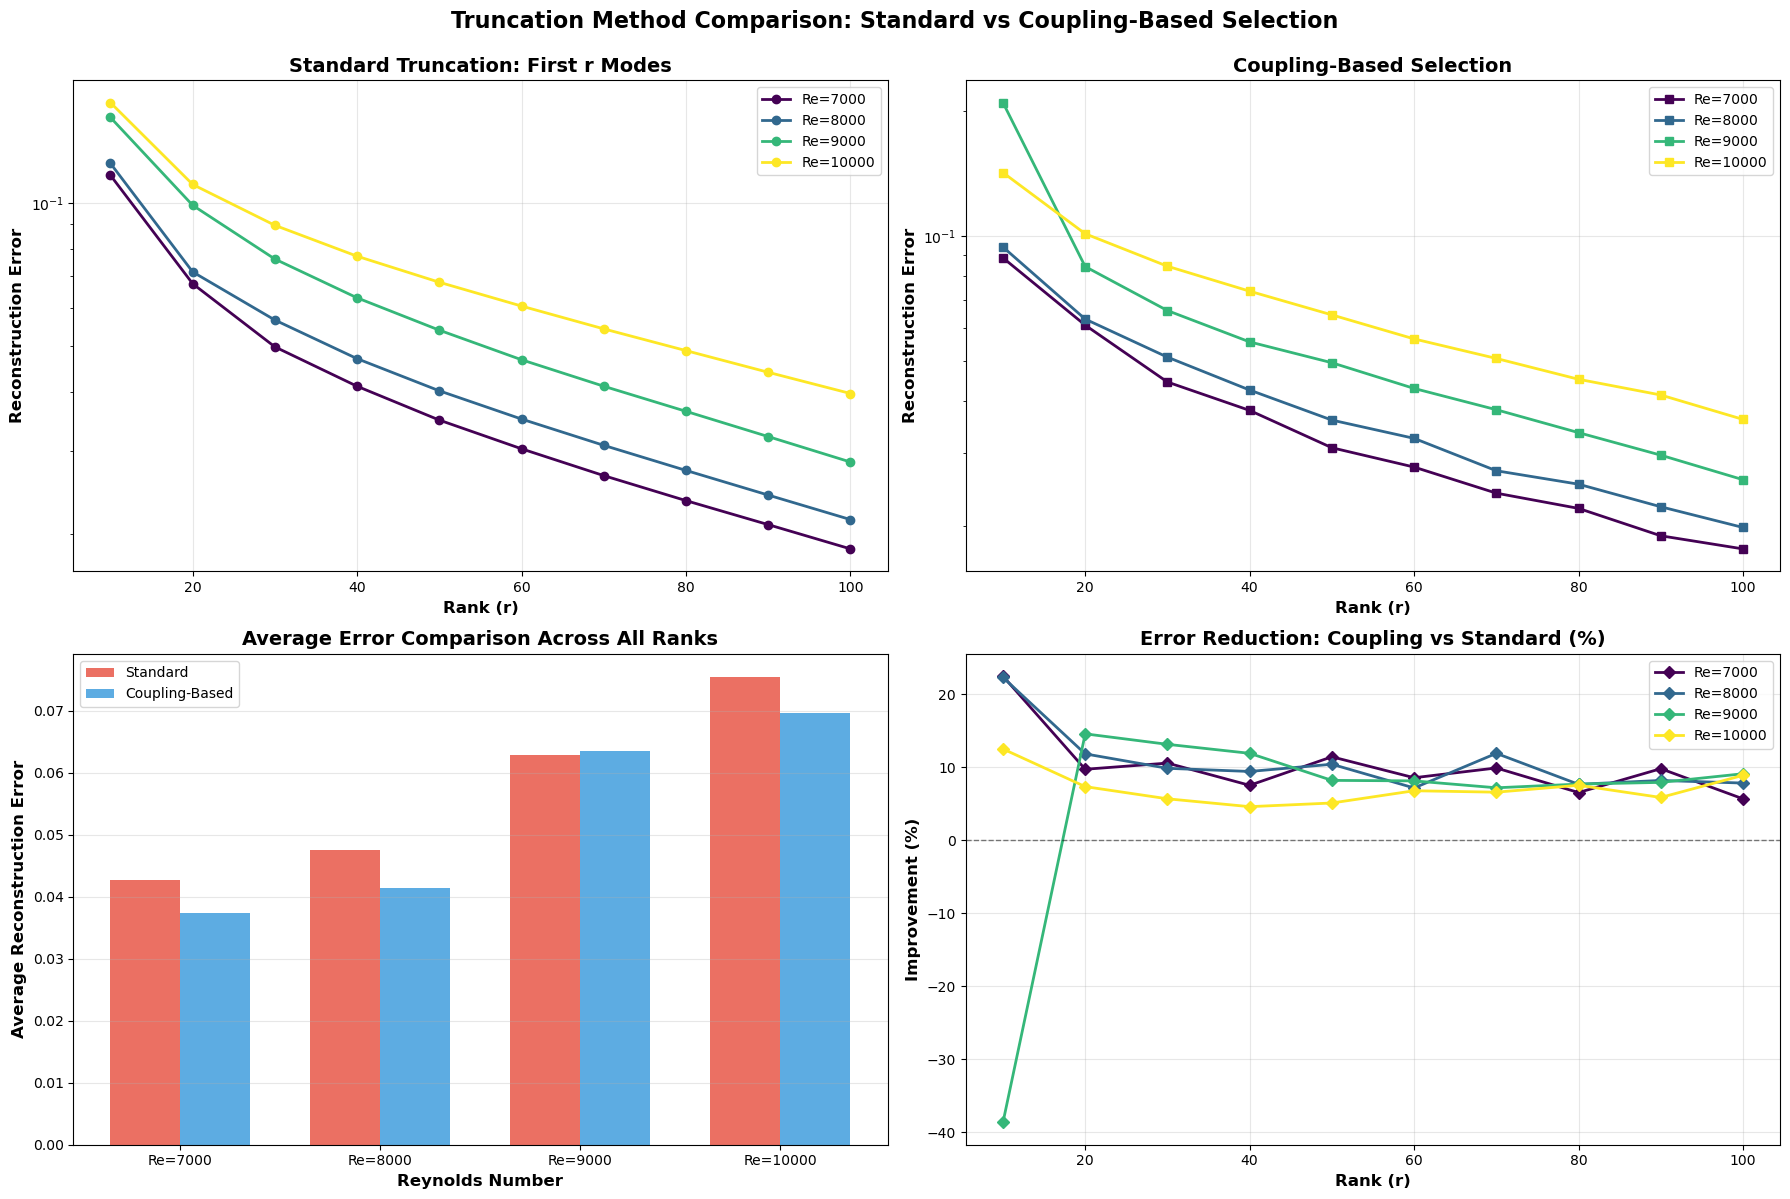


SUMMARY STATISTICS: TRUNCATION METHOD COMPARISON

Re = 7000:
  Average Error:
    Standard:       0.042743
    Coupling-Based: 0.037296
    Improvement:    12.74%
  Min Error:
    Standard:       0.018645 (rank=100)
    Coupling-Based: 0.017587 (rank=100)
  Max Error:
    Standard:       0.114259 (rank=10)
    Coupling-Based: 0.088570 (rank=10)

Re = 8000:
  Average Error:
    Standard:       0.047503
    Coupling-Based: 0.041344
    Improvement:    12.97%
  Min Error:
    Standard:       0.021496 (rank=100)
    Coupling-Based: 0.019811 (rank=100)
  Max Error:
    Standard:       0.121049 (rank=10)
    Coupling-Based: 0.094042 (rank=10)

Re = 9000:
  Average Error:
    Standard:       0.062771
    Coupling-Based: 0.063514
    Improvement:    -1.18%
  Min Error:
    Standard:       0.028421 (rank=100)
    Coupling-Based: 0.025830 (rank=100)
  Max Error:
    Standard:       0.151278 (rank=10)
    Coupling-Based: 0.209735 (rank=10)

Re = 10000:
  Average Error:
    Standard:       0.0753

In [17]:
# ============================================
# VISUALIZATION: TRUNCATION METHOD COMPARISON
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

colors_re = plt.cm.viridis(np.linspace(0, 1, len(reynolds_numbers)))

# Plot 1: Error vs Rank for all Re (Standard method)
ax = axes[0]
for idx, re in enumerate(reynolds_numbers):
    key = f"Re{re}"
    ranks = comparison_results[key]['ranks']
    errors_standard = comparison_results[key]['errors_standard']
    ax.plot(ranks, errors_standard, 'o-', color=colors_re[idx], 
            linewidth=2, markersize=6, label=f'Re={re}')

ax.set_xlabel('Rank (r)', fontsize=12, fontweight='bold')
ax.set_ylabel('Reconstruction Error', fontsize=12, fontweight='bold')
ax.set_title('Standard Truncation: First r Modes', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 2: Error vs Rank for all Re (Coupling-based method)
ax = axes[1]
for idx, re in enumerate(reynolds_numbers):
    key = f"Re{re}"
    ranks = comparison_results[key]['ranks']
    errors_coupling = comparison_results[key]['errors_coupling']
    ax.plot(ranks, errors_coupling, 's-', color=colors_re[idx], 
            linewidth=2, markersize=6, label=f'Re={re}')

ax.set_xlabel('Rank (r)', fontsize=12, fontweight='bold')
ax.set_ylabel('Reconstruction Error', fontsize=12, fontweight='bold')
ax.set_title('Coupling-Based Selection', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 3: Direct comparison for each Re
ax = axes[2]
x_pos = np.arange(len(reynolds_numbers))
width = 0.35

# Average error across all ranks
avg_errors_standard = [np.mean(comparison_results[f"Re{re}"]['errors_standard']) 
                       for re in reynolds_numbers]
avg_errors_coupling = [np.mean(comparison_results[f"Re{re}"]['errors_coupling']) 
                       for re in reynolds_numbers]

bars1 = ax.bar(x_pos - width/2, avg_errors_standard, width, 
               label='Standard', alpha=0.8, color='#E74C3C')
bars2 = ax.bar(x_pos + width/2, avg_errors_coupling, width, 
               label='Coupling-Based', alpha=0.8, color='#3498DB')

ax.set_xlabel('Reynolds Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Reconstruction Error', fontsize=12, fontweight='bold')
ax.set_title('Average Error Comparison Across All Ranks', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'Re={re}' for re in reynolds_numbers])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Improvement percentage
ax = axes[3]
for idx, re in enumerate(reynolds_numbers):
    key = f"Re{re}"
    ranks = comparison_results[key]['ranks']
    errors_standard = np.array(comparison_results[key]['errors_standard'])
    errors_coupling = np.array(comparison_results[key]['errors_coupling'])
    
    improvement = ((errors_standard - errors_coupling) / errors_standard) * 100
    
    ax.plot(ranks, improvement, 'D-', color=colors_re[idx], 
            linewidth=2, markersize=6, label=f'Re={re}')

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Rank (r)', fontsize=12, fontweight='bold')
ax.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Error Reduction: Coupling vs Standard (%)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

fig.suptitle('Truncation Method Comparison: Standard vs Coupling-Based Selection', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================
# PRINT SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS: TRUNCATION METHOD COMPARISON")
print(f"{'='*80}\n")

for re in reynolds_numbers:
    key = f"Re{re}"
    errors_standard = np.array(comparison_results[key]['errors_standard'])
    errors_coupling = np.array(comparison_results[key]['errors_coupling'])
    
    avg_standard = np.mean(errors_standard)
    avg_coupling = np.mean(errors_coupling)
    avg_improvement = ((avg_standard - avg_coupling) / avg_standard) * 100
    
    min_error_standard = np.min(errors_standard)
    min_error_coupling = np.min(errors_coupling)
    
    max_error_standard = np.max(errors_standard)
    max_error_coupling = np.max(errors_coupling)
    
    print(f"Re = {re}:")
    print(f"  Average Error:")
    print(f"    Standard:       {avg_standard:.6f}")
    print(f"    Coupling-Based: {avg_coupling:.6f}")
    print(f"    Improvement:    {avg_improvement:.2f}%")
    print(f"  Min Error:")
    print(f"    Standard:       {min_error_standard:.6f} (rank={comparison_results[key]['ranks'][np.argmin(errors_standard)]})")
    print(f"    Coupling-Based: {min_error_coupling:.6f} (rank={comparison_results[key]['ranks'][np.argmin(errors_coupling)]})")
    print(f"  Max Error:")
    print(f"    Standard:       {max_error_standard:.6f} (rank={comparison_results[key]['ranks'][np.argmax(errors_standard)]})")
    print(f"    Coupling-Based: {max_error_coupling:.6f} (rank={comparison_results[key]['ranks'][np.argmax(errors_coupling)]})")
    print()

print(f"{'='*80}")